In [2]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import requests # this is to access the stim urls from the notebook
from IPython.display import SVG, display # need for showing stims with sketches side by side
import base64
import PIL

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# so dataframes don't get cut off in display:
pd.set_option("display.max_rows", None, "display.max_columns", None)

import ast  # for interpreting strings as dictionary objects

# if you want the cells to be the width of your browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [3]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [5]:
# set vars 
auth = pd.read_csv(os.path.join(os.getcwd(),'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['num_syn']
coll = db['exp3']

# which iteration name(s) should we use?
iterationName = 'run1'  # 'dave' / 'seb' were for Dave / Sebastian to test it out; 'run1'

w = coll.find({'iterationName':iterationName})    
W = pd.DataFrame(w)

# Quickly anonymise the gameIDs and cast a few columns into the forms we want them to be
W[['gameID']] = W[['gameID']].applymap(lambda x: "G" + str(int(np.where(W.gameID.unique() == x)[0])+1))
W = W.astype({'correct':'float',
              'totalScore':'float'})
W['totalScore'] = W['totalScore'] / 100

W['syntax'] = W['condition'].apply(lambda x: x != 'no_syntax')
W['count']  = W['condition'].apply(lambda x: x != 'no_count' )

Wraw = W # keep a backup


W.to_csv("datastructures/numsyn3Data_incl_{}.csv".format(iterationName))

print("Done")

Done


In [6]:
# # see the comments
# coll.find({'eventType':'survey'}).distinct("comments")

# Wraw[Wraw['prolificID'].isin(['57d5ab3a722df500017f3622','5ccef4423f15b900199e1ec3','57acc170c6bab4000172a42e','581ccd016c73180001fa5b2a'])].gameID.unique()

# Wraw[Wraw['gameID'] == 'G95']

,_id,iterationName,eventType,finalCount,gameID,workerID,assignmentID,hitID,prolificID,studyID,sessionID,score,totalScore,trialNum,sectionTrial,cardinality,base,condition,target,response,correct,take,distractions,trialStartTime,takeStartTime,trialTime,takeTime,RT,WT,initTime,endTime,targetWord,targetNum,responseSide,responseNumber,responseWord,otherNumber,otherWord,missed,gender,age,comments,understood,totalLength,syntax,count
0,63cd831858c4334a66b04453,run1,tutorial,False,G1,,,,6117c2cae28082d793313e88,63cc988c2a276a3b63c222e6,63cd82bff781865b8ec222f5,$0,0.00,1.0,0.0,1.0,5,no_syntax,ho-ka,hoka,1.0,0.0,{},1.674413e+12,1.674413e+12,3556.0,3556.0,2452,1104,1.674413e+12,1.674413e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
1,63cd831c58c4334a66b04454,run1,quiz,False,G1,,,,6117c2cae28082d793313e88,63cc988c2a276a3b63c222e6,63cd82bff781865b8ec222f5,$0.03,0.03,1.0,0.0,1.0,5,no_syntax,ho-ka,hoka,1.0,0.0,{},1.674413e+12,1.674413e+12,3008.0,3008.0,1839,1169,1.674413e+12,1.674413e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2,63cd832158c4334a66b04455,run1,tutorial,False,G1,,,,6117c2cae28082d793313e88,63cc988c2a276a3b63c222e6,63cd82bff781865b8ec222f5,$0.03,0.03,2.0,1.0,2.0,5,no_syntax,ho,ho,1.0,0.0,{},1.674413e+12,1.674413e+12,3542.0,3542.0,3077,465,1.674413e+12,1.674413e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
3,63cd832458c4334a66b04456,run1,quiz,False,G1,,,,6117c2cae28082d793313e88,63cc988c2a276a3b63c222e6,63cd82bff781865b8ec222f5,$0.06,0.06,2.0,1.0,2.0,5,no_syntax,ho,ho,1.0,0.0,{},1.674413e+12,1.674413e+12,1714.0,1714.0,1193,521,1.674413e+12,1.674413e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
4,63cd832658c4334a66b04457,run1,tutorial,False,G2,,,,6047c853ca7cb206a40f555b,63cc988c2a276a3b63c222e6,63cd82d586100bcee1422586,$0,0.00,1.0,0.0,1.0,5,control,ko,ko,1.0,0.0,{},1.674413e+12,1.674413e+12,6297.0,6297.0,4703,1594,1.674413e+12,1.674413e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True


## Sort out Payment

In [5]:
paid = ["63cd82d586100bcee1422586",
        "63cd8a33aec0ccabcf0f9ba9",
        "63cd82d3d1db04dd3a8b1a7e",
        "63cd82c14591a1ba4aae1fd5",
        "63cd84b768ef36286ff6a67c",
 '63cd90c10f37f94030b23326',
 '63cd90c44be8b78b74a7aeb9',
 '63cd90c4f14ec57c2519fd7e',
 '63cd90be5988031c4d19fd51',
 '63cd90bc2e4b038c93a054a4',
 '63cd90c4250365c43225b031',
 '63cd90befec356cac6a7ae7b',
 '63cd90c4daa27a66f65b28f4',
 '63cd90bff81f65ef9a5c5db3',
 '63cd90c2196ce7878f4ac0b7',
 '63cd90c11efbbd6889ece753',
 '63cd90b9e156153dbb489c0a',
 '63cd95bcb254cb0c61635f63',
 '63cd90bdfec356cac6a7ae7a',
 '63cd90bf64f73b22f7d9d73c',
 '63cd90c3a185ef91a71d54ae',
 '63cd90c28add84e03ab9e0b7',
 '63cd923d5988031c4d19fd7f',
 '63cd90c5b1711dec65761f5a',
 '63cd90c104ce9aaee32c8ab4',
 '63cd90e0d825b43936d79d24',
 '63cd90bf29f960a6dfa33969',
 '63cd90bccb4ee70c05e4eae7',
 '63cd90c5957ca83dce489bfb',
 '63cd933088b23f7a11c71c73',
 '63cd90c30e1b3e2d0512253c',
 '63cd90c347455e4a5512254a',
 '63cd90bd2f55d45f96b9e10d',
 '63cd90c2a458c0073ab23311',
 '63cd90bb574360aaf178d455',
 '63cd90c08db3dcffe43fd1bf',
        '60fc3971c59904a050e60007', # couldn't get past generalization
        '63cd90c5893eb15084761fc9', # couldn't get past generalization?
        '63cd90c10e1b3e2d0512253b', # timed out... not sure what happened
        '63cd9834b8aa68399e35b32e', # just took a while, should be with the above
        '63cd9e6336f4e5485c0f9bd2',
        '63cda43840732785268b1a5d', # couldn't get past generalization
        '63cda43a9078afb643c22296', # couldn't get past generalization
        '63cda458ad359d197db9e102',
 '63cda432c1c6fa7c66ae1fb0',
 '63cda43a4f2cca03682c8a94',
 '63cda432903e7830ca5670fd',
 '63cda43327073c58d4422554',
 '63cda43625a37333ea987774',
 '63cda435c050682a8d35b2e1',
 '63cda43010f8545a23c71c6e',
 '63cda433a5782f6217e4ea9c',
 '63cda43909462933aeebf989',
 '63cda432f338dc3127c71c51',
 '63cda4388fb846075b99ead4',
 '63cda43818c6b07f462c118b',
 '63cda42fc750a65768ece732',
 '63cda438447d4a82a35c5dcc',
 '63cda42e9be07d8a69ccfeee',
 '63cda431eaa70cd95f1d5491',
 '63cda42fce8927f18ad9d76a',
 '63cda437ff9f04b17d761f4f',
 '63cda4371aec6dfe7fa054b6',
 '63cda6ed70d34e17f319fd1d',
 '63cda42db77fcb7d5099ea8f',
 '63cda434aa9f81592de4eabe',
        '63cdae4553165de0a9122585',
 '63cda4379c911ebce62c11bd',
 '63cda439cefb285ddf3fd19e',
 '63cda7e0c2a3abca42635f51',
 '63cda8b8542e749ef9b2336e',
 '63cda4321c076dd38cc222d4',
 '63cda432ae132721f3b9e0f8',
 '63cda4368a2cdaa01df6a650',
 '63cda43abdd322c7034ac075',
 '63cda43a7a714a2f42a3398b',
 '63cda439d5b820d970c71c87',
 '63cda43964b2bd79ab694430',
 '63cda6a088c72c9f20d79d2c',
 '63cda4351ed8300640694472',
 '63cda4336ea406b65498774f',
        '63ceeba8f8faa86fc577c740', # Sebastian messed up. Might actually be fine
 '63ceebaaf42db2ec6b4679a2', # Sebastian messed up. Might actually be fine
 '63ceed0087aab0193eeeffbd', # Sebastian messed up. Might actually be fine
 '63ceeba99c6a8e83f3ef0009',  # Sebastian messed up. Might actually be fine
 '63cef5255845c41ae24c787a',
 '63cef525a9c426d9f277c72b',
 '63cef525878a474baef0b768',
 '63cef524d14da46d1ae3bc1b',
 '63cef5248fc6c15c62b4791a',
        '63cefeb3b7fd4a02bd4c7809',
 '63cefeb3bae5b554995d8de9',
 '63cf0118051908fa5b02bc82',
 '63cefeb11c1fe32200c80280',
 '63cefeb4deb591796597e688',
 '63cefeb1553af48bc60cf6ea',
 '63cefeb25e9f0295fd66bac9',
 '63cefeb6abd1abdbdc0cf00f',
 '63cefeb4b48f0f9aa4bd9f7b',
 '63cefeb5eab90219f3f67475',
        '63cf091551b3d631a5a55866',
 '63cf09143b0b1f191df674b8',
 '63cf091223027e815c348c48',
 '63cf09138541af91e70cf6f3',
 '63cf091700297aa324348c0a',
 '63cf0990b1585efafab478c8',
 '63cf0916e2a6ded73c241671',
 '63cf09154d8b7dac1a41f6b6',
 '63cf09130fbad06302c80273',
 '63cf090eecbfea432377c727',
 '63cf09131c0b835e7541f6e7',
 '63cf0915bdacc72b9576bc27',
        '63d0291589d51016f6bd2064', # last day - they keep failing. Need two more games at this point....
 '63d029165d99c387c76db8fd',
 '63d02917a8dd6ac0b3415691',
 '63d0291598255d02d47405f2',
 '63d0291850f4661e643168b8',
 '63d02774748bf661d98965f0',
 '63d0319a8f259d3596dca3a7',
        '63d03fca9f88116daa832e24', # last three!
 '63d03e39f1fc65e48550b033',
 '63d03e382b2094a1328a1707'
       ]


payDF = W[W['eventType'] == 'survey'][~W['sessionID'].isin(paid)][['prolificID','sessionID','totalScore']].sort_values('totalScore',ascending=False)

for row in payDF.drop_duplicates(subset=["prolificID"], keep='first').iterrows():
    print(row[1]['prolificID'] + ',' + str(row[1]['totalScore']))

for row in payDF.drop_duplicates(subset=["prolificID"], keep='first').iterrows():
    print(row[1]['prolificID'] + ',')

list(payDF['sessionID'].unique())

61506f90721dcdeca6e77c2d,2.47
5f761e5106b786071f45b4aa,2.46
5f6214a59413141f7cb2508c,2.42
61506f90721dcdeca6e77c2d,
5f761e5106b786071f45b4aa,
5f6214a59413141f7cb2508c,


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


['63d03fca9f88116daa832e24',
 '63d03e39f1fc65e48550b033',
 '63d03e382b2094a1328a1707']

In [6]:

# need to give reward to:
temp = Wraw[Wraw['prolificID'] == "5c53a7c6035fc4000159cc99"]
temp[temp['totalScore'] == temp['totalScore'].max()].drop('target',axis=1)

len(Wraw.prolificID.unique())

128

## Define Helper Functions

In [7]:
def parse(string, units, measure='len'):
    """
    Take a string that participant gave, and a list of strings (units in number system).
    Looks to see if the participant's response can be broken down into units.
    Return either how many units could be found, or the remaining length of the string.
    """
    st = string # I never remember if you need to make a shallow copy this way
    ct = 0      # count how many 'units' there are in message
    for unit in units:
        ct += st.count(unit)
        st = st.replace(unit,'-') # placeholder so we don't accidentally produce a syllable in unit list
        
    st = st.replace('-','') # now remove the placeholder
#     answer = ct if measure == 'count' else len(st) # decide which number to give
    return np.array([ct,len(st)])

def gloss(string,system):
    st = string if type(string)==str else " " # if it's a nan, then forget about it
    for entry in system:
        char_gloss = "-"+str(entry[0])+"-" if entry[1] != 'nan' else "-nan-" # in early exps, we only did up to 15
        st = st.replace(entry[1],char_gloss) # replace number word (entry[1]) with Arabic gloss (entry[0])
        st = st.replace("--","-")
        st = st[:-1] if st.endswith('-') else st
        st = st[1: ] if st.startswith('-') else st
    return st

def LD(token1, token2):
    """This function gives us the Levenshtein distance between two strings.
    We will use it to cluster games into categories based on which model strategies they are closest to"""
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

def get_confint(df):
    """Takes a df already with columns ['Factors','mean','count','std']
    and gives a dataframe with confidence interval of high and low estimates"""
    new_df = df
    ci95_hi = []
    ci95_lo = []
    for i in new_df.index:
        m, c, s = new_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    new_df['ci95_hi'] = ci95_hi
    new_df['ci95_lo'] = ci95_lo
    return new_df



## Do Some Preliminary Visualizations

Text(0.5, 1.0, 'Distractions in each Game')

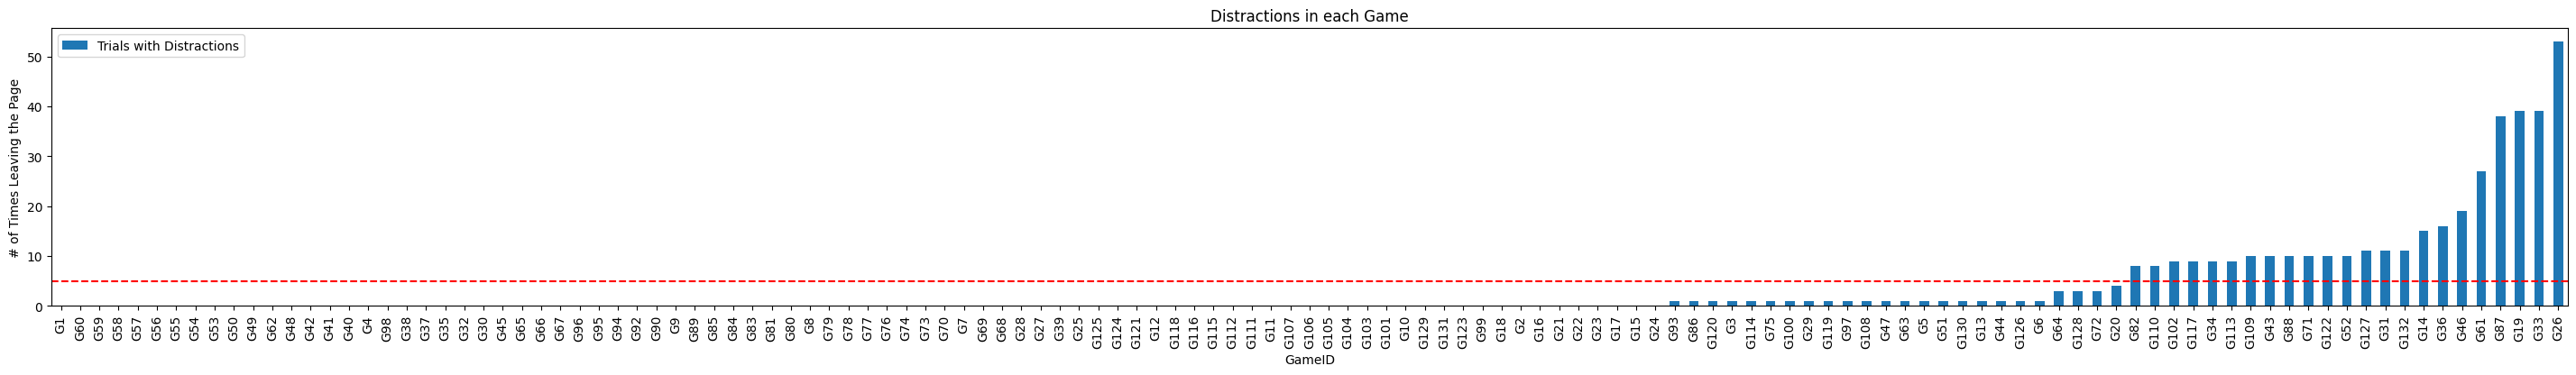

In [460]:
# how often were people 'distracted' by flipping between screens?
Wraw['distracted'] = Wraw[['distractions']].applymap(lambda x: 'blurred' in x.values()) # when did people leave the screen
distractedTrials = Wraw.groupby(['gameID','trialNum'])[['distracted']].agg({'distracted':lambda x: bool(sum(x))}) # identify distracted trials
distractedTrialFreq = distractedTrials.groupby(['gameID'])[['distracted']].sum().sort_values('distracted') # how often did each game have a trial with a distraction?
distractedTrialFreq = distractedTrialFreq.rename(columns={'distracted':'Trials with Distractions'})
distractedTrialFreq.plot.bar(figsize=(36,4))
plt.axhline(5,c='r',ls='--')
plt.xlabel("GameID")
plt.ylabel("# of Times Leaving the Page")
plt.title("Distractions in each Game")

## Excluding Games

In [9]:
# Before we start excluding, how many total games are there in each condition?
print("\033[1mHow many TOTAL games are there in each condition (valid or not)?\033[0m")
for b in Wraw.groupby(['condition'])['gameID'].unique().index:
    print("Condition: {}: {} games".format(b,len(Wraw.groupby(['condition'])['gameID'].unique()[b])))
print()

# How many total games with GENERALIZATION are there in each condition?
print("\033[1mHow many TOTAL games with GENERALIZATION are there in each condition (valid or not)?\033[0m")
for b in Wraw[Wraw['eventType'] == 'generalization'].groupby(['condition'])['gameID'].unique().index:
    print("Condition: {}: {} games".format(b,len(Wraw[Wraw['eventType'] == 'generalization'].groupby(['condition'])['gameID'].unique()[b])))
print()

print("\033[1mHow many in total then?\033[0m")
print("Total games: {} games".format(len(Wraw[Wraw['eventType'] == 'quiz'].gameID.unique())))
print("Games with generalization: {} games".format(len(Wraw[Wraw['eventType'] == 'generalization'].gameID.unique())))


How many TOTAL games are there in each condition (valid or not)?
Condition: control: 42 games
Condition: no_count: 42 games
Condition: no_syntax: 48 games

How many TOTAL games with GENERALIZATION are there in each condition (valid or not)?
Condition: control: 39 games
Condition: no_count: 38 games
Condition: no_syntax: 42 games

How many in total then?
Total games: 131 games
Games with generalization: 119 games


In [10]:
# Actual exclusions go in this cell


# First, find those people who took the experiment multiple times
temp = pd.DataFrame(Wraw.groupby(["prolificID"])['gameID'].unique())
temp = temp[temp['gameID'].apply(lambda x: len(x) > 1)]
# now mark any game past their first one, because they are no longer naive to the task:
duplicates = np.squeeze(list(temp['gameID']))[:,1:].flatten()
W['duplicate'] = W['gameID'].isin(duplicates)

manual_exclusions = ['63ceeba8f8faa86fc577c740','63ceebaaf42db2ec6b4679a2','63ceed0087aab0193eeeffbd','63ceeba99c6a8e83f3ef0009'] # may have seen generalization phase
manual_exclusions = ['63cda4336ea406b65498774f',  # browser auto-translated number-word text to Ukrainian in ordinality phase
                     '63d0319a8f259d3596dca3a7']  # also some weird font thing, possibly auto-translate
W['manualExclude'] = W['sessionID'].isin(manual_exclusions)


# tell whether on any given trial the person left the webpage for whatever reason
W['distracted'] = W[['distractions']].applymap(lambda x: 'blurred' in x.values()) # when did people leave the screen
distractedTrials = W.groupby(['gameID','trialNum'])[['distracted']].agg({'distracted':lambda x: bool(sum(x))}) # identify distracted trials
distractedTrialFreq = distractedTrials.groupby(['gameID'])[['distracted']].sum().sort_values('distracted') # how often did each game have a trial with a distraction?
distractedTrialGames = distractedTrialFreq[distractedTrialFreq['distracted'] > 6].index # set the cutoff point
# these two lines just take how many times in total they got distracted in the game - not grouped by trial
# distractedFreq = W.groupby(['gameID'])[['distracted']].sum().sort_values('distracted')
# distractedGames = distractedFreq[distractedFreq['distracted'] > 6].index
W['distractedGame'] = W['gameID'].isin(distractedTrialGames) # now create a column to tell us if it was a distracted game or not

# set up a little datastructure to use for excluding based on game accuracy (only look at people's first try)
temp = W[W['eventType'] == 'quiz'][W['take']==0].groupby('gameID').mean()[['correct']]

# identify games that were below absolute accuracy threshold
failedGames = temp[temp['correct'] < .5].index
W['failedGame'] = W['gameID'].isin(failedGames)

# identify games that were below relative accuracy threshold
cutoff = float(temp.mean() - np.std(temp)*3) # get cutoff
temp = temp[temp['correct'] < cutoff].index
W['failedOutlier'] = W['gameID'].isin(temp)

# for if we only want to look at games that got to the final (64th) quiz trial
qizGames = set(W[W['trialNum'] == 64]['gameID'].unique())

# for if we only want to look at games with generalization trial
genGames = set(W[W['eventType'] == 'generalization']['gameID'].unique())

# for if we only want to look at games with magnitude comparison trials
ordGames = set(W[W['eventType'] == 'ordinality']['gameID'].unique())

# now take only the games for which the above things are all true:
completeGames = list(qizGames.intersection(genGames).intersection(ordGames))

W['complete'] = W['gameID'].isin(completeGames)


# now identify games that used irrelevant characters in too many trials
# # bad way to do it because not everyone finished the generalization trial, but I don't want to delete cause it took forever
# gameChars = W[W['eventType'] == 'generalization'][["gameID","target"]].applymap(lambda x: # get a set of permissable letters per game  
#                                                                                 set(str(x).translate(
#                                                                                     str(x).maketrans(",[]'", "    "))) # exclude these
#                                                                                 if type(x)==list else x) # do it for target, not gameID     

# for each game, find all the characters that belong in the count list
gameChars = W[W['eventType'] == 'quiz'].groupby(['gameID'])[['target']].agg({"target":lambda x:
                                                                        x.str.cat()}).applymap(lambda x:
                                                                                               set(x).union(set(x.upper()).union(set(' '))))
# make it a searchable dictionary ({gameID : character_set})
gameCharDict = pd.Series(gameChars.target.values,index=gameChars.index).to_dict()

responseChars = W.groupby(['gameID','trialNum'])[['response']].agg({"response":lambda x:
                                                                    x.str.cat()}).applymap(lambda x:
                                                                                           set(x)).reset_index()    
responseChars['gameChars'] = responseChars[['gameID']].applymap(lambda x: gameCharDict[x])
responseChars['intersection'] = responseChars['response'] - responseChars['gameChars']
responseChars['intersection'] = responseChars[['intersection']].applymap(lambda x: bool(len(x)))
nonsenseFreq = responseChars.groupby('gameID')[['intersection']].sum() > 3
nonsenseGames = nonsenseFreq[nonsenseFreq['intersection'] == True].index
W['nonsenseGame'] = W['gameID'].isin(nonsenseGames)


# now filter all those games out - if you want to exclude based on generalization, do it here
W = W[W['failedOutlier'] == False][W['distractedGame'] == False
                                  ][W['failedGame'] == False
                                   ][W['complete'] == True
                                    ][W['nonsenseGame'] == False
                                     ][W['duplicate'] == False
                                      ][W['manualExclude'] == False]

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserW

In [11]:
# How many valid games are there in each condition?
print("\033[1mHow many valid games are there in each condition?\033[0m")
for b in W.groupby(['condition'])['gameID'].unique().index:
    print("Condition: {}: {} games".format(b,len(W.groupby(['condition'])['gameID'].unique()[b])))
print()

print("\033[1mHow many in total then?\033[0m")
print("Total games: {} games".format(len(W.gameID.unique())))


How many valid games are there in each condition?
Condition: control: 30 games
Condition: no_count: 30 games
Condition: no_syntax: 31 games

How many in total then?
Total games: 91 games


<AxesSubplot:xlabel='prolificID', ylabel='trialStartTime'>

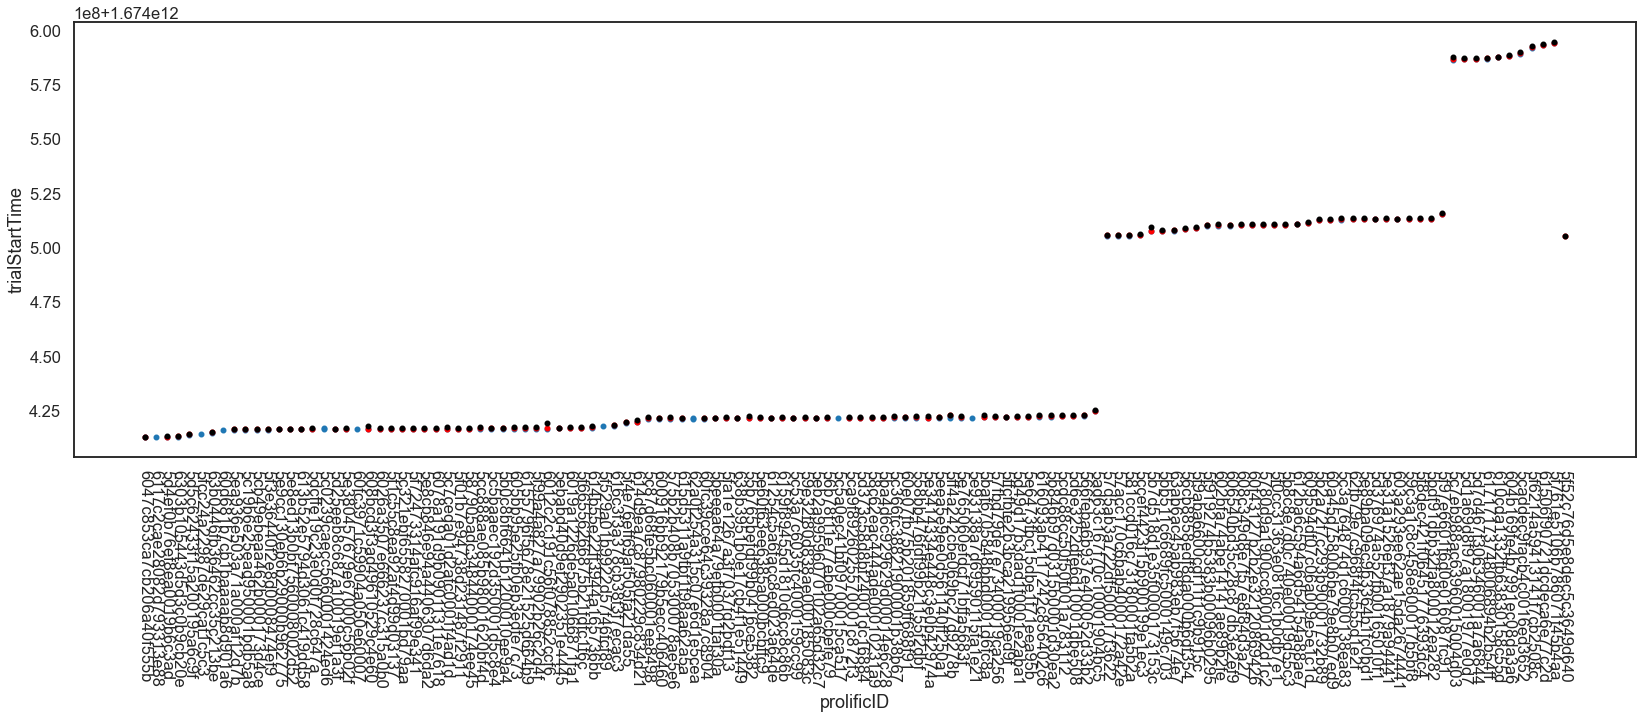

In [12]:
## this was to discover that people were not being shown the generalization trial due to answering wrong on the last quiz trial:
# qizGames = W[W['trialNum'] == 64]['gameID'].unique()
# genGames = W[W['eventType'] == 'generalization']['gameID'].unique()
# rejects = set(qizGames).difference(genGames)
# r = W[W['gameID'].isin(list(rejects))]
# r[r['trialNum']==64][['gameID','correct','condition']]

f , ax = plt.subplots(1,1,figsize=(28,8),sharex=True)
temp = Wraw[Wraw['eventType']=='quiz'].groupby(['prolificID','gameID'])[['trialStartTime']].mean().reset_index()
temp.sort_values('trialStartTime', ascending=True, inplace=True) # first, let's sort this list by when their average quiz trial was
temp.plot.scatter(x='prolificID',y='trialStartTime',ax=ax) # and now add it to the plot
Wraw[Wraw['eventType']=='generalization'].groupby(['prolificID','gameID'])[['trialStartTime']].mean().reset_index().plot.scatter(x='prolificID',y='trialStartTime',ax=ax,c='red')
Wraw[Wraw['eventType']=='ordinality'].groupby(['prolificID','gameID'])[['trialStartTime']].mean().reset_index().plot.scatter(x='prolificID',y='trialStartTime',ax=ax,c='k',rot=270)


In [13]:
# save out the cleaned datastructure to a .csv that we can also analyse in R
W.to_csv("datastructures/numsyn3Data_excl_{}.csv".format(iterationName))

# /////////////////////////////////////////////////////////////////////////////
# /////////////////////////////////////////////////////////////////////////////
# /////////////////////////////////////////////////////////////////////////////
# ----------------------------------------------------------------------
# Start From Here once you have Datastructure Saved

In [14]:
# load in the cleaned datastructure from the .csv
W = pd.read_csv("datastructures/numsyn3Data_excl_{}.csv".format(iterationName))



# Analyses

In [993]:
# First, let's separate out each trial type so that we can analyse them separately
T = W[W['eventType']=='tutorial']
Q = W[W['eventType']=='quiz']
G = W[W['eventType']=='generalization']
S = W[W['eventType']=='survey']
O = W[W['eventType']=='ordinality']

Q = Q.astype({'RT':'float','WT':'float'})
# remove the first instance of each cardinality from quiz trials (it is not very informative)
Q = Q.groupby(['gameID','cardinality']).apply(lambda x:  x.tail(-1)   ).drop(['gameID','cardinality'],axis=1).reset_index().set_index('level_2')
Q.index.rename('index')

# also only ever look at the first take for now
Q = Q[Q['take']==0]

# every syllable past the first one has a hyphen
Q['numSyls'] = Q.target.str.count('-')+1

# our pre-registered time DV looks like this:
Q['timeDV'] = Q.RT + (Q.WT / Q.response.str.len())

# add some new columns to the quiz trial df
Q['normedWT'] = (Q.WT / Q.response.str.len())
Q['RTLessWrite'] = Q['RT'] - Q['WT']
Q['RTLessNormedWrite'] = Q['RT'] - Q['normedWT']
Q['RTPlusNormedWrite'] = Q['RT'] + Q['normedWT']

# now record the cumulative frequency for the target cardinality in every quiz trial
temp = Q[['trialNum','gameID','cardinality']]
Q['frequency'] = temp.apply(lambda x: Q.loc[
    Q['trialNum'] < x['trialNum']].loc[
    Q['gameID']==x['gameID']].loc[
    Q['cardinality']==x['cardinality']]['cardinality'].count(),axis=1)


O = O.astype({'RT':float})
O['acc'] = O['targetNum'] == O['otherNumber']
O['distractorNum'] = O[['responseNumber','otherNumber']].min(axis=1)
O['diff'] = O['targetNum'] - O['distractorNum']
O['syllDiff'] = O[['responseWord','otherWord']].apply(lambda x: abs(int((len(x['responseWord'].replace('-','')) - len(x['otherWord'].replace('-','')))/2)),
                                      axis=1)
temp = O[['gameID','targetNum','distractorNum']]
O['frequency'] = temp.apply(lambda x: Q.loc[Q['gameID']==x['gameID']].loc[Q['cardinality'].isin([x['targetNum'],x['distractorNum']])]['cardinality'].count(),axis=1 )
O['numsum'] = O['targetNum'] + O['distractorNum']
O['numdif'] = O['targetNum'] - O['distractorNum']

print('Done')

Done


In [1009]:
# make our measure of efficiency
Q['efficiency'] = np.nan

for gameid in Q['gameID'].unique():
    if np.nanvar(Q[Q['gameID'] == gameid]['correct']) != 0:
        zScoreAcc = stats.zscore(Q[Q['gameID'] == gameid]['correct'],nan_policy='omit')
    else:
        zScoreAcc = np.zeros(len(Q[Q['gameID'] == gameid]['correct'])) # is this the right way to do this?
    zScoreDur = stats.zscore(Q[Q['gameID'] == gameid]['timeDV'],nan_policy='omit')
    efficiency = zScoreAcc - zScoreDur
    for trialnum in Q[Q['gameID']==gameid]['trialNum'].unique():
        curGame = Q.loc[Q['gameID'] == gameid]
        ind = curGame[curGame['trialNum'] == trialnum].index[0]
        Q['efficiency'][ind] = efficiency[ind] # efficiency[ind] used to be efficiency[int(trialnum-1)] (which incorrectly resets per game)

# make our measure of efficiency
O['efficiency'] = np.nan

for gameid in O['gameID'].unique():
    if np.nanvar(O[O['gameID'] == gameid]['correct']) != 0:
        zScoreAcc = stats.zscore(O[O['gameID'] == gameid]['correct'],nan_policy='omit')
    else:
        zScoreAcc = np.zeros(len(O[O['gameID'] == gameid]['correct'])) # is this the right way to do this?
    zScoreDur = stats.zscore(O[O['gameID'] == gameid]['RT'],nan_policy='omit')
    efficiency = zScoreAcc - zScoreDur
    for trialnum in O[O['gameID']==gameid]['endTime'].unique():
        curGame = O.loc[O['gameID'] == gameid]
        ind = curGame[curGame['endTime'] == trialnum].index[0]
        O['efficiency'][ind] = efficiency[ind] # efficiency[ind] used to be efficiency[int(trialnum-1)] (which incorrectly resets per game)


In [1132]:

# Adding feature columns for the base-5 number system, as in the other analysis notebook:
b5_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[1,0,0,0],6:[0,1,0,0],7:[0,1,0,0],8:[0,1,0,0],9:[0,1,0,0],10:[0,0,1,0]}
b_dicts = {5:b5_features} # based on base-condition in each row, know which dict to use

# now for each row, look up base and cardinality and assign the vector to the new columns
Q[['prim','add','mult','exp']] = Q.apply(lambda x: pd.Series(b_dicts[x['base']][x['cardinality']],
                                                             index=['prim','add','mult','exp']) if x['condition'] != 'no_syntax' else pd.Series([1,0,0,0],
                                                                                                                                                index=['prim','add','mult','exp']),
                                         axis=1)

# here's that sum we were going to compute
Q['feature_sum'] = Q[['prim','add','mult','exp']].apply(lambda x: sum(x), axis=1)

# now for each row, look up base and cardinality and assign the vector to the new columns
# for the ordinality task, it's a bit tricker: we have two numbers! For now, we'll just take the max of each vector, e.g. [0,1,0,0] & [1,0,0,0] -> [1,1,0,0]
# like this: list(np.max(np.array([[0,1,0,0],[1,0,0,0]]),axis=0))
O[['prim','add','mult','exp']] = O.apply(lambda x: pd.Series(list(np.max(np.array([b_dicts[x['base']][x['targetNum']],
                                                                                   b_dicts[x['base']][x['distractorNum']]]),axis=0)),
                                                             index=['prim','add','mult','exp']) if x['condition'] != 'no_syntax' else pd.Series([1,0,0,0],
                                                                                                                                                index=['prim','add','mult','exp']),
                                         axis=1)
# here's one where it's 1 is a mult and add are in competition during that trial, and 0 otherwise
O[['MvsA']] = O.apply(lambda x: pd.Series(np.sum(list(np.max(np.array([b_dicts[x['base']][x['targetNum']],
                                                         b_dicts[x['base']][x['distractorNum']]]),axis=0))[1:3])==2,
                                   index=['MvsA']) if x['condition'] != 'no_syntax' else pd.Series([0],
                                                                                                   index=['MvsA']),
               axis=1)

# here's another for when there are two additive items
O[['AvsA']] = O.apply(lambda x: pd.Series(list(np.sum(np.array([b_dicts[x['base']][x['targetNum']],
                                                         b_dicts[x['base']][x['distractorNum']]]),axis=0))[1]==2,
                                   index=['AvsA']) if x['condition'] != 'no_syntax' else pd.Series([0],
                                                                                                   index=['AvsA']),
               axis=1)

# here's another for when there are two lexical primitives (units)
O[['UvsU']] = O.apply(lambda x: pd.Series(list(np.sum(np.array([b_dicts[x['base']][x['targetNum']],
                                                         b_dicts[x['base']][x['distractorNum']]]),axis=0))[0]==2,
                                   index=['UvsU']) if x['condition'] != 'no_syntax' else pd.Series([0],
                                                                                                   index=['UvsU']),
               axis=1)


# here's that sum we were going to compute
O['feature_sum'] = O[['prim','add','mult','exp']].apply(lambda x: sum(x), axis=1)



In [1168]:
# now save the ones that matter

Q.to_csv("datastructures/numsynQ3.csv")
O.to_csv("datastructures/numsynO3.csv")

In [1164]:

# old DF, took the max of each row (add, mult, etc)

# mult > add ~ prim
# word-length 2

#          N    >    M
# add      0         0
# mult     0         0



#          N    >    M
# add      1         1
# mult     0         0




#          N    >    M
# add      1         0
# mult     0         1

#          N    >    M
# add      0         1
# mult     1         0



# if the whole array above == 2, then the wordlength is identical, and it becomes interesting
# equal wordlength by itself is uninteresting, because all pairs of numbers <5 have this, but no rules of compositions


# replacing np.max with np.sum is a version of that measure that asks how many instances there are of each type of rule in the whole problem
# what's the problem with this measure in a regression? If there are 0 instances of addition, then it's hard. 1 instance? Easy. 2 instances? Hard again. Non-linear
# but if we only ask "are there two mults? Two adds?" And are interested in no fewer
# O[['prims','adds','mults','exps']] = O.apply(lambda x: pd.Series(list(np.sum(np.array([b_dicts[x['base']][x['targetNum']],
#                                                                                    b_dicts[x['base']][x['distractorNum']]]),axis=0)==2),
#                                                              index=['prims','adds','mults','exps']) if x['condition'] != 'no_syntax' else pd.Series([1,0,0,0],
#                                                                                                                                                 index=['prims','adds','mults','exps']) ,
#                                          axis=1)

# colnames = ['MvsA']

# O.head().apply(lambda x: pd.Series(np.sum(list(np.sum(np.array([b_dicts[x['base']][x['targetNum']],
#                                                          b_dicts[x['base']][x['distractorNum']]]),axis=0))[1:3])==2,
#                                    index=['MvsA']) if x['condition'] != 'no_syntax' else pd.Series([0],
#                                                                                                    index=['MvsA']),
#                axis=1)

O[O['MvsA']==True]['responseNumber'].unique()


# here's one where it's 1 is a mult and add are in competition during that trial, and 0 otherwise
O[['MvsA']] = O.apply(lambda x: pd.Series(np.sum(list(np.max(np.array([b_dicts[x['base']][x['targetNum']],
                                                         b_dicts[x['base']][x['distractorNum']]]),axis=0))[1:3])==2,
                                   index=['MvsA']) if x['condition'] != 'no_syntax' else pd.Series([0],
                                                                                                   index=['MvsA']),
               axis=1)


In [1167]:
O['XvsX'] = O['UvsU'] + O['AvsA']*2 + O['MvsA']*3

O[['targetNum','distractorNum','UvsU','AvsA','MvsA','XvsX']].head(20)

O['XvsX'].max()

3

In [1120]:
lo = float(Q[['RT']].mean() - np.std(Q[['RT']])*3) # get cutoff
hi = float(Q[['RT']].mean() + np.std(Q[['RT']])*3) # get cutoff


Qclean = Q[Q['RT'].apply(lambda x: (x > lo) & (x < hi))]

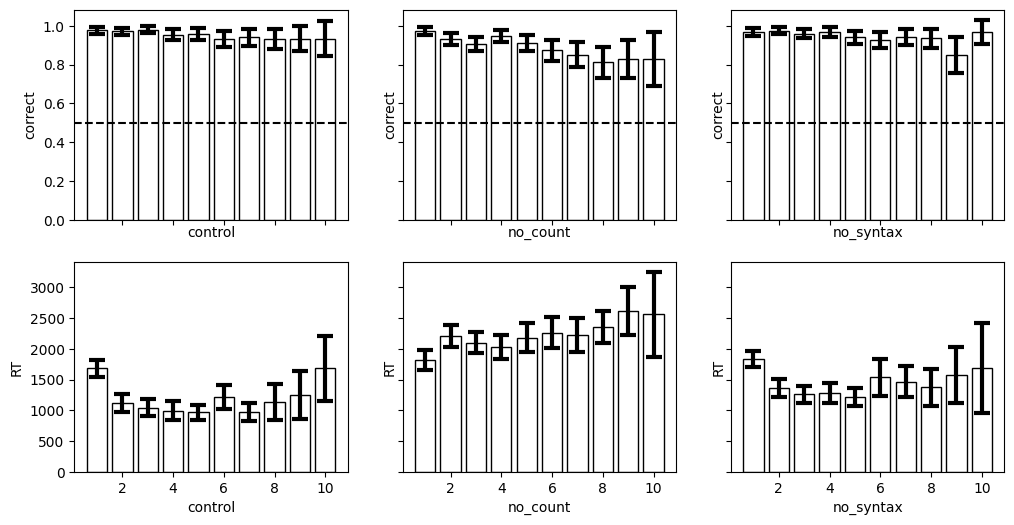

In [1131]:
# O[O['targetNum'] == 10].groupby(['distractorNum'])[['correct']].mean().plot()
# O[O['condition']=='no_syntax'].groupby(['numsum'])[['RT']].mean().plot(ax=ax1,c='r')



f , ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(12,6),sharey='row',sharex=True)
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for i,dv in enumerate(['correct','RT']):
    for j,cond in enumerate(['control','no_count','no_syntax']):
        ax = axes[i*3+j]
        
        temp = Qclean[Qclean['condition'].isin([cond])]
        temp = get_confint(pd.DataFrame(temp.groupby(['cardinality'])[[dv]].agg(['mean', 'count', 'std'])))
        
        ax.bar(temp.reset_index()['cardinality'],
                height=temp[dv]['mean'],
                width=.8,
                yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
               edgecolor='k',color='w',
                error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})
        if dv == 'correct':
            ax.axhline(.5,c='k',linestyle='--')
        ax.set_ylabel("{}".format(dv))
        ax.set_xlabel("{}".format(cond))



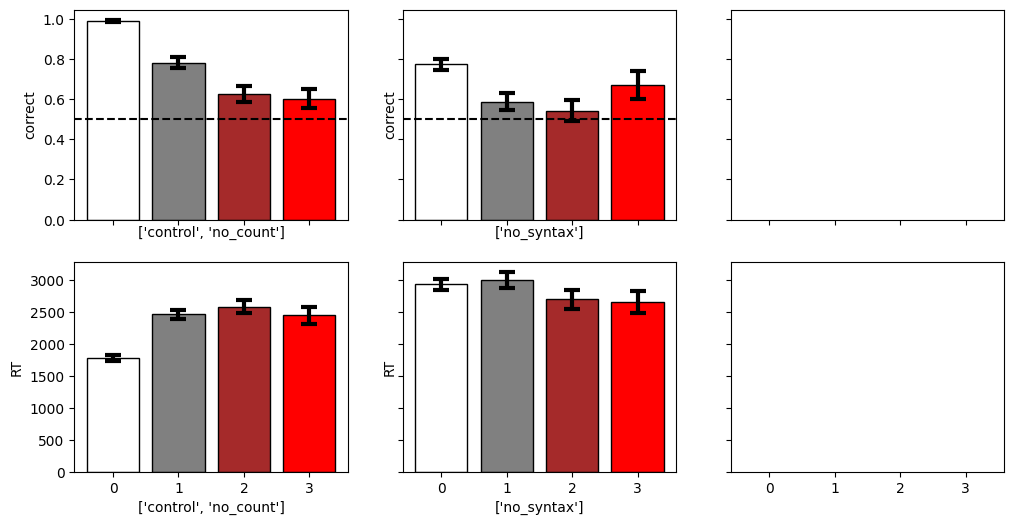

In [1086]:
# O[O['targetNum'] == 10].groupby(['distractorNum'])[['correct']].mean().plot()
# O[O['targetNum'].isin([6,7,8,9]) | O['targetNum'].isin([10])].groupby(['distractorNum'])[['RT']].mean().plot()

## These 4 account for all possible trials:
# O["U_U"] = O['targetNum'].isin([1,2,3,4,5]) & O['distractorNum'].isin([1,2,3,4,5]) # unit and unit comparison
# O["A_A"] = O['targetNum'].isin([6,7,8,9]) & O['distractorNum'].isin([6,7,8,9]) # additive and additive comparison
# O["M_A"] = O['targetNum'].isin([10]) & O['distractorNum'].isin([6,7,8,9]) # multiplicative and additive comparison
# O['diffSyls'] = O[["U_U","A_A","M_A"]].apply(lambda x: np.sum(x) == 0,axis=1) # do the numbers differ in number of syllables (binary, unlike syllDiff)
# O['compType'] = O[["diffSyls","U_U","A_A","M_A"]].apply(lambda x: np.argmax(x),axis=1) # what kind of comparison is it? Vague name, sorry


# O[O['condition']=='control'].groupby(['compType'])['RT'].mean().plot.bar()


f , ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(12,6),sharey='row',sharex=True)
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for i,dv in enumerate(['correct','RT']):
    for j,cond in enumerate([['control','no_count'],['no_syntax']]):
        ax = axes[i*3+j]
        temp = get_confint(pd.DataFrame(O[O['condition'].isin(cond)].groupby(['compType'])[[dv]].agg(['mean', 'count', 'std'])))
        
        ax.bar(temp.reset_index()['compType'],
                height=temp[dv]['mean'],
                width=.8,
                yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
               edgecolor='k',color=['w','grey','brown','r'],
                error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})
        if dv == 'correct':
            ax.axhline(.5,c='k',linestyle='--')
        ax.set_ylabel("{}".format(dv))
        ax.set_xlabel("{}".format(cond))


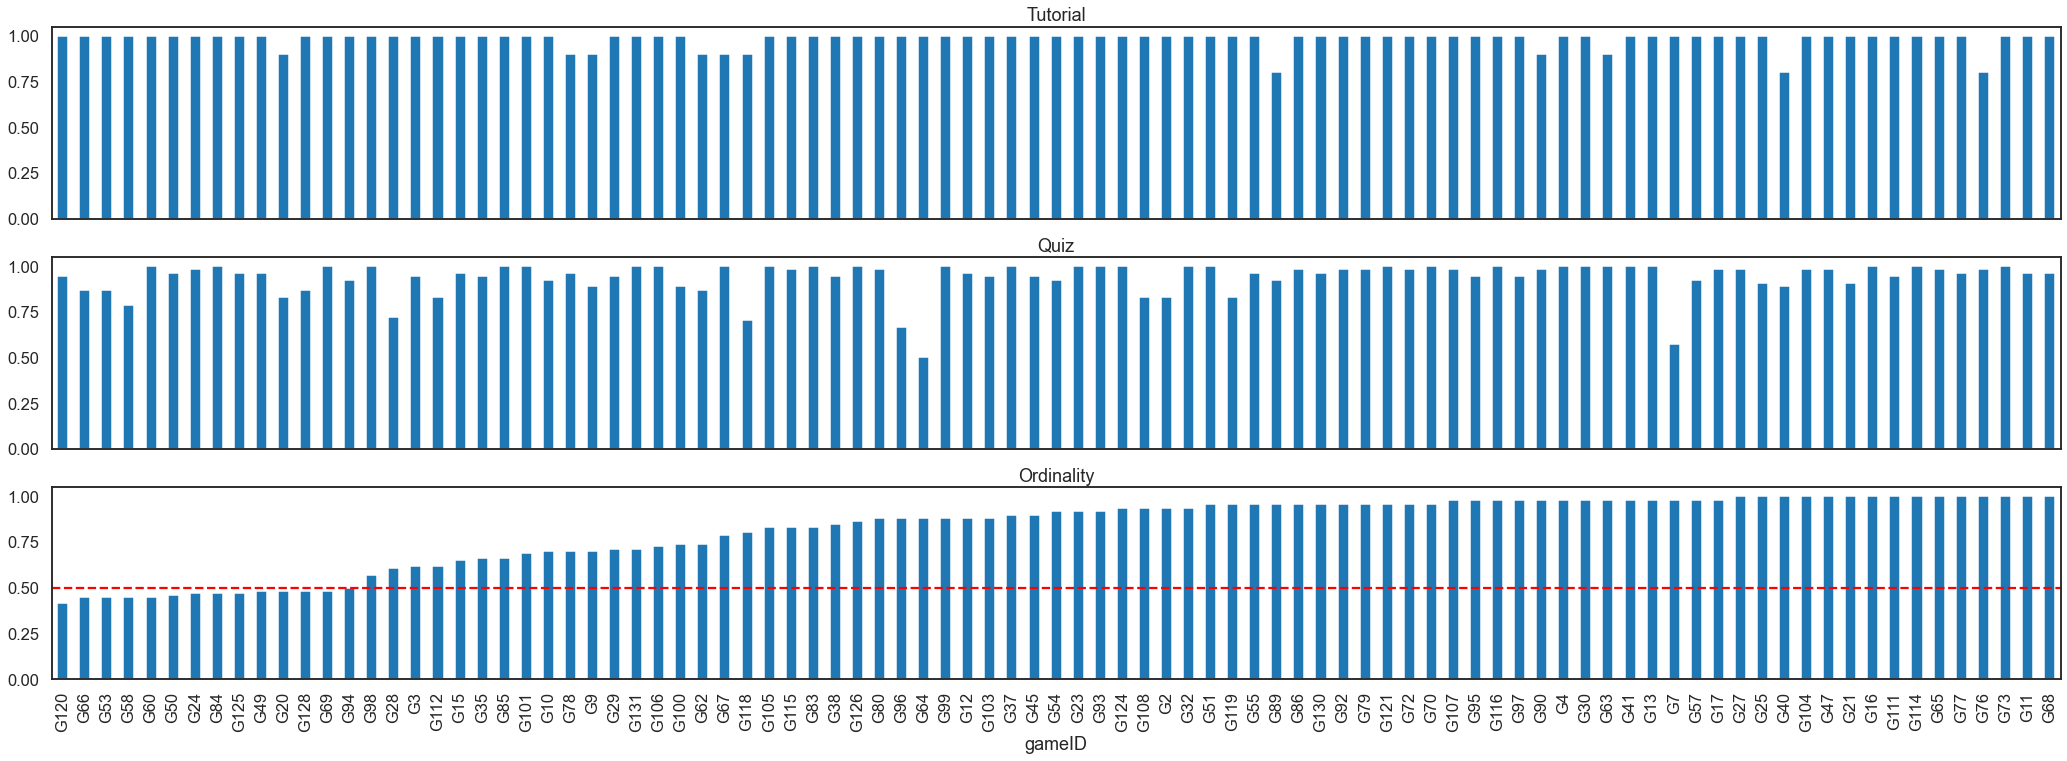

In [17]:
f , axs = plt.subplots(3,1,figsize=(36,12),sharey=True,sharex=True)

T.groupby('gameID')[['correct']].mean().plot.bar(ax=axs[0],title='Tutorial',legend=False)
Q.groupby('gameID')[['correct']].mean().plot.bar(ax=axs[1],title='Quiz',legend=False)
O.groupby('gameID')[['correct']].mean().sort_values('correct').plot.bar(ax=axs[2],title='Ordinality',legend=False)  # only useful when there's ordinal trials to compare
axs[2].axhline(y=.5,c='r',linestyle='--')

[Text(0, 0, 'Control'), Text(1, 0, 'No Count'), Text(2, 0, 'No Syntax')]

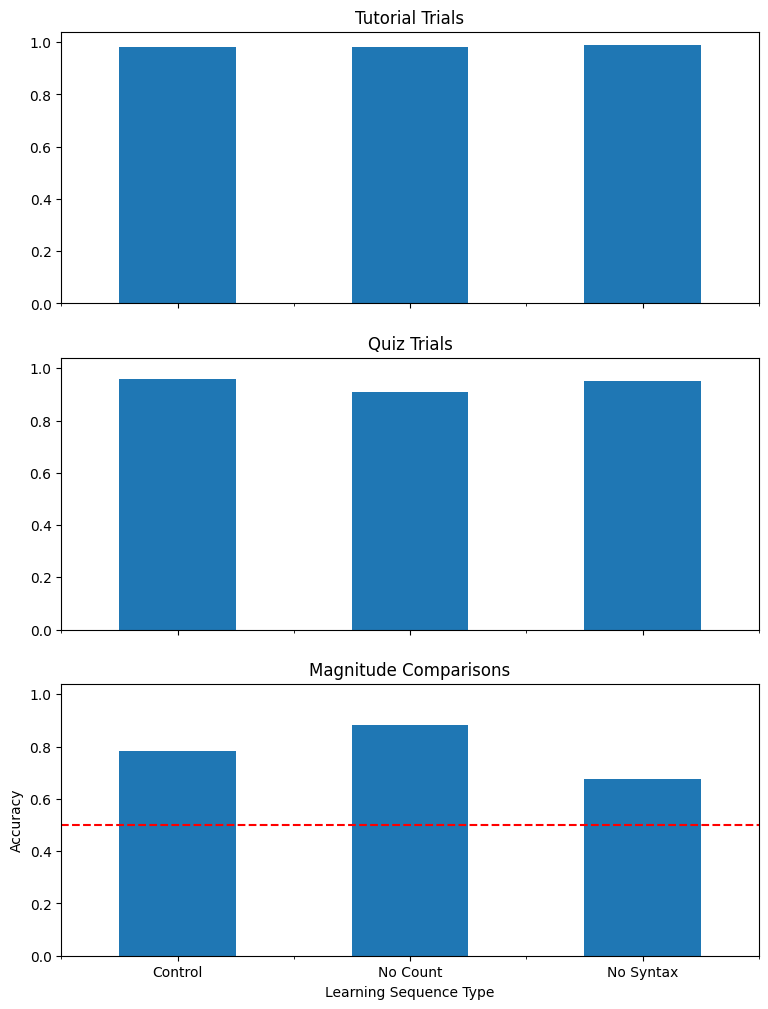

In [461]:
f , axs = plt.subplots(3,1,figsize=(9,12),sharex=True,sharey=True)
T.groupby(['condition'])[['correct']].mean().plot.bar(ax=axs[0],title='Tutorial Trials',legend=False)
Q.groupby(['condition'])[['correct']].mean().plot.bar(ax=axs[1],title='Quiz Trials',legend=False)
O.groupby(['condition'])[['correct']].mean().plot.bar(ax=axs[2],title='Magnitude Comparisons',legend=False)
axs[2].axhline(y=.5,c='r',linestyle='--')
axs[2].set_ylabel("Accuracy")
axs[2].set_xlabel("Learning Sequence Type")
axs[2].set_xticklabels(["Control","No Count","No Syntax"],rotation=0)



[Text(1.0, 0, '1'),
 Text(2.0, 0, '2'),
 Text(3.0, 0, '3'),
 Text(4.0, 0, '4'),
 Text(5.0, 0, '5'),
 Text(6.0, 0, '6'),
 Text(7.0, 0, '7'),
 Text(8.0, 0, '8'),
 Text(9.0, 0, '9'),
 Text(10.0, 0, '10')]

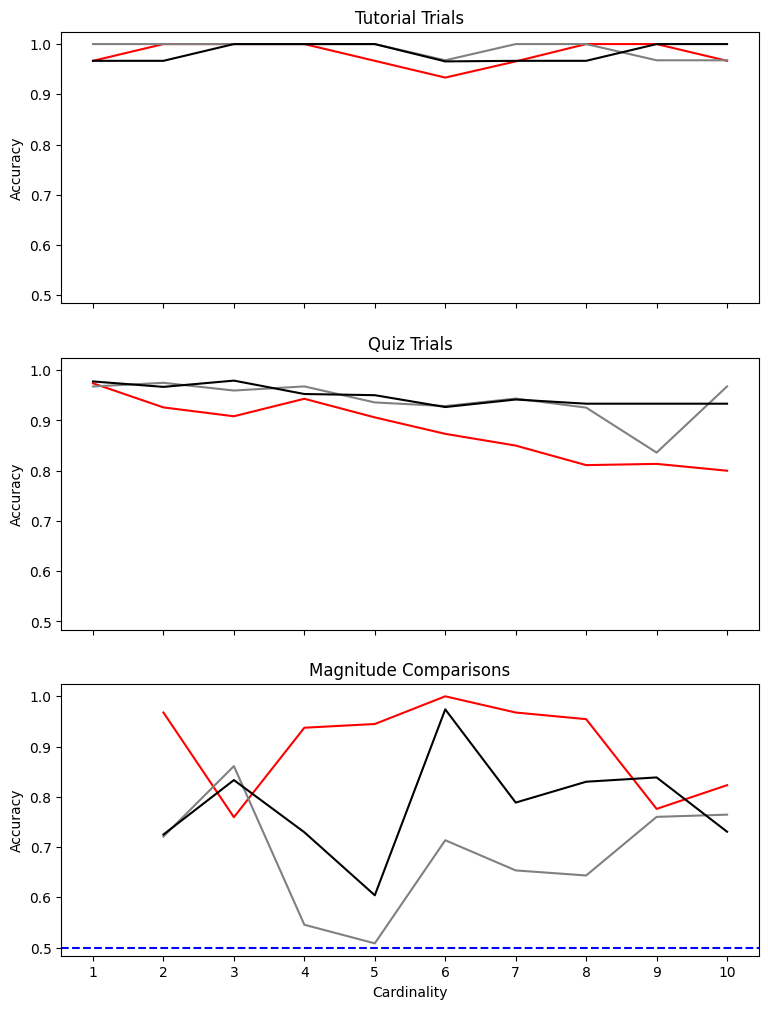

In [462]:
f , axs = plt.subplots(3,1,figsize=(9,12),sharex=True,sharey=True)

T[T['condition']=='no_count'   ].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[0],title='Tutorial Trials',legend=False, c='red')
T[T['condition']=='no_syntax'].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[0],title='Tutorial Trials',legend=False, c='grey')
T[T['condition']=='control' ].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[0],title='Tutorial Trials',legend=False, c='k')

Q[Q['condition']=='no_count'   ].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[1],title='Quiz Trials',legend=False, c='red')
Q[Q['condition']=='no_syntax'].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[1],title='Quiz Trials',legend=False, c='grey')
Q[Q['condition']=='control' ].groupby(['cardinality'])[['correct']].mean().plot(ax=axs[1],title='Quiz Trials',legend=False, c='k')


O[O['condition']=='no_count'   ].groupby(['targetNum'])[['correct']].mean().plot(ax=axs[2],title='Magnitude Comparisons',legend=False, c='red')
O[O['condition']=='no_syntax'].groupby(['targetNum'])[['correct']].mean().plot(ax=axs[2],title='Magnitude Comparisons',legend=False, c='grey')
O[O['condition']=='control' ].groupby(['targetNum'])[['correct']].mean().plot(ax=axs[2],title='Magnitude Comparisons',legend=False, c='k')

axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Accuracy")
axs[2].set_ylabel("Accuracy")

axs[2].set_xlabel("Cardinality")
axs[2].set_xticks(Q.cardinality.unique())
axs[2].axhline(y=.5,c='b',linestyle='--')
axs[2].set_xticklabels(Q.cardinality.unique().astype(int),rotation=0)


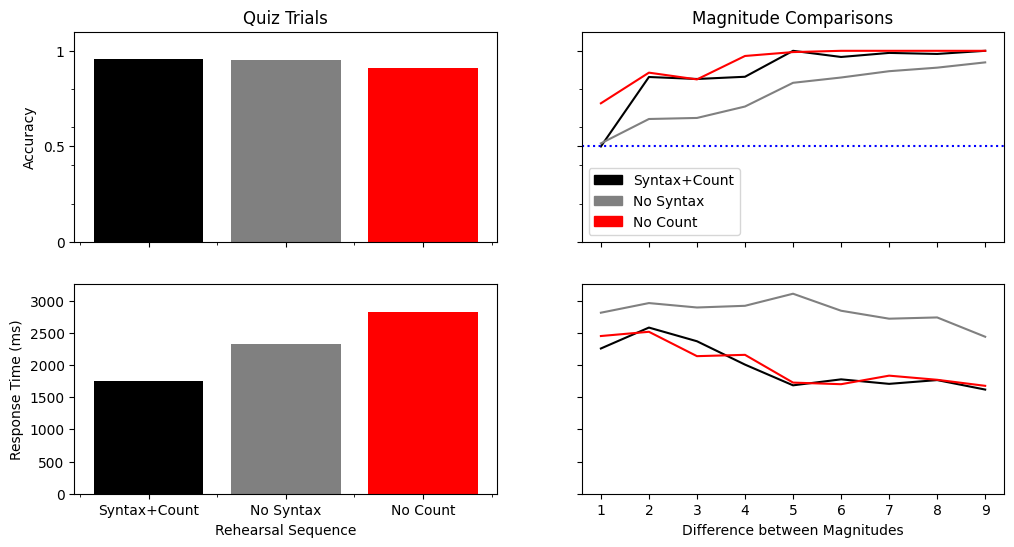

In [1095]:


f , ax = plt.subplots(2,2,figsize=(12,6),sharex='col', sharey='row')

ax[0,0].bar(x=['Syntax+Count','No Syntax', 'No Count'], height=[Q[Q['condition']=='control'][['correct']].mean()[0],
                                                                Q[Q['condition']=='no_syntax'][['correct']].mean()[0],
                                                                Q[Q['condition']=='no_count'][['correct']].mean()[0]], color=['k','grey','r'])
ax[1,0].bar(x=['Syntax+Count','No Syntax', 'No Count'], height=[Q[Q['condition']=='control'][['RTPlusNormedWrite']].mean()[0],
                                                                Q[Q['condition']=='no_syntax'][['RTPlusNormedWrite']].mean()[0],
                                                                Q[Q['condition']=='no_count'][['RTPlusNormedWrite']].mean()[0]], color=['k','grey','r'])
ax[0,0].set_title("Quiz Trials")
ax[1,0].set_xlabel("Rehearsal Sequence")


Q[Q['condition']=='control'][['correct']].mean()
# Q.groupby('condition')[['correct']].mean().plot.bar(ax=ax[0,0],title='Quiz Trials',color=['k','grey','r'])


O[O['condition']=='control'].groupby('diff')[['correct']].mean().plot(ax=ax[0,1],title='Magnitude Comparisons',c='k',label="Syntax+Count")
O[O['condition']=='no_syntax'].groupby('diff')[['correct']].mean().plot(ax=ax[0,1],c='grey',label="No Syntax")
O[O['condition']=='no_count'].groupby('diff')[['correct']].mean().plot(ax=ax[0,1],c='red',label="No Count")

ax[0,1].set_ylim(0,1.1)
ax[0,1].set_yticks([0,.5,1])
ax[0,1].set_yticklabels([0,.5,1])
ax[0,1].axhline(y=.5,c='b',linestyle=':')


O[O['condition']=='control'].groupby('diff')[['RT']].mean().plot(ax=ax[1,1],c='k',legend=False)
O[O['condition']=='no_syntax'].groupby('diff')[['RT']].mean().plot(ax=ax[1,1],c='grey',legend=False)
O[O['condition']=='no_count'].groupby('diff')[['RT']].mean().plot(ax=ax[1,1],c='red',legend=False)

ax[1,1].set_xlabel("Difference between Magnitudes")
ax[0,1].set_xticks(np.arange(1,10))
ax[0,1].set_xticklabels(np.arange(1,10),rotation=0)

ax[0,0].set_ylabel("Accuracy")
ax[1,0].set_ylabel("Response Time (ms)")


blk_patch = mpatches.Patch(color='k', label='Syntax+Count')
gry_patch = mpatches.Patch(color='grey', label='No Syntax')
red_patch = mpatches.Patch(color='red', label='No Count')

ax[0,1].legend(handles=[blk_patch, gry_patch, red_patch])



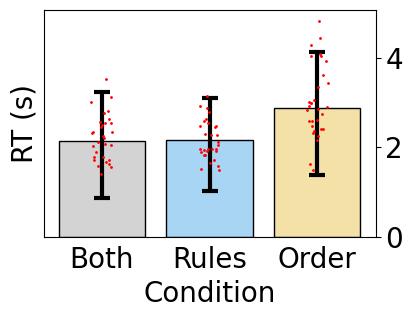

In [682]:
# cogsci_old

f , ax = plt.subplots(1,1, figsize=(4,3))

CIctrl = np.array(get_confint(O[O['condition']=='control'][['RT']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['RT']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['RT']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T

ax.bar(x=['Both', 'Rules', 'Order'],
       height=[O[O['condition']=='control'][['RT']].mean()[0],
               O[O['condition']=='no_count'][['RT']].mean()[0],
               O[O['condition']=='no_syntax'][['RT']].mean()[0]],
       color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
       yerr=np.squeeze(np.array([CIctrl,CInoco,CInosy]).T),
       error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})


for i,cond in enumerate(['control','no_count','no_syntax']):
        ax.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['RT']].mean()))* .2 - .1,
                    O[O['condition']==cond].groupby(['gameID'])[['RT']].mean(),
                    zorder=10,s=1,c='r')

ax.set_ylabel("RT (s)")
ax.set_yticks([0,2000,4000])
ax.set_yticklabels([0,2,4])
ax.yaxis.tick_right()
ax.set_xlabel("Condition")

plt.tight_layout()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

    
f.savefig('../results/plots/cogsci23/Exp2mag_RT.pdf', bbox_inches="tight")


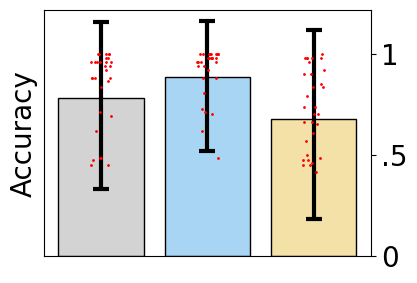

In [681]:
# cogsci_old

f , ax = plt.subplots(1,1, figsize=(4,3))

CIctrl = np.array(get_confint(O[O['condition']=='control'][['correct']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['correct']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['correct']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T

ax.bar(x=['Both', 'Rules', 'Order'],
       height=[O[O['condition']=='control'][['correct']].mean()[0],
               O[O['condition']=='no_count'][['correct']].mean()[0],
               O[O['condition']=='no_syntax'][['correct']].mean()[0]],
       color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
       yerr=np.squeeze(np.array([CIctrl,CInoco,CInosy]).T),
       error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})


for i,cond in enumerate(['control','no_count','no_syntax']):
        ax.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['correct']].mean()))* .2 - .1,
                    O[O['condition']==cond].groupby(['gameID'])[['correct']].mean(),
                    zorder=10,s=1,c='r')

ax.set_ylabel("Accuracy")
ax.set_yticks([0,.5,1])
ax.set_yticklabels(["0",".5","1"])
ax.yaxis.tick_right()
# ax.set_xlabel("Condition")

plt.tight_layout()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

    
f.savefig('../results/plots/cogsci23/Exp2mag_acc.pdf', bbox_inches="tight")


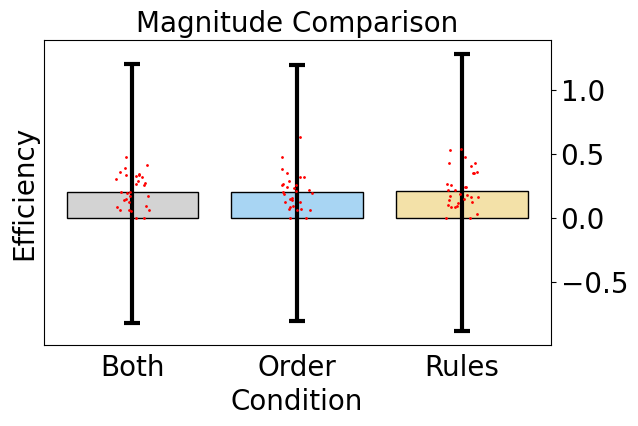

In [556]:
# cogsci_old
f , ax = plt.subplots(1,1, figsize=(6,4))

# get rid of outliers
O['clean_eff'] = O['efficiency']
O.loc[O['clean_eff'] < -2.5, 'clean_eff'] = np.nan


CIctrl = np.array(get_confint(O[O['condition']=='control'][['clean_eff']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['clean_eff']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['clean_eff']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T

ax.bar(x=['Both','Order', 'Rules'],
       height=[O[O['condition']=='control'][['clean_eff']].mean()[0],
               O[O['condition']=='no_count'][['clean_eff']].mean()[0],
               O[O['condition']=='no_syntax'][['clean_eff']].mean()[0]],
       color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
       yerr=np.squeeze(np.array([CIctrl,CInoco,CInosy]).T),
       error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})


for i,cond in enumerate(['control','no_count','no_syntax']):
        ax.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['clean_eff']].mean()))* .2 - .1,
                    O[O['condition']==cond].groupby(['gameID'])[['clean_eff']].mean(),
                    zorder=10,s=1,c='r')

ax.set_title("Magnitude Comparison")
ax.set_ylabel("Efficiency")
# ax.set_yticks([0,.5,1])
# ax.set_yticklabels(["0",".5","1"])
ax.yaxis.tick_right()
ax.set_xlabel("Condition")

plt.tight_layout()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

    
# f.savefig('../results/plots/cogsci23/Exp2mag_eff.pdf', bbox_inches="tight")


<AxesSubplot:ylabel='Frequency'>

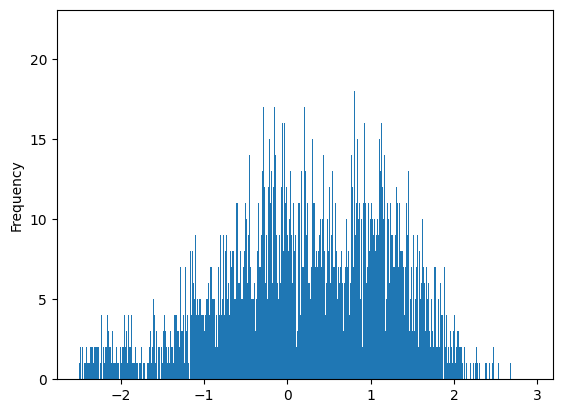

In [555]:
O['clean_eff'].plot.hist(bins=1000)


(11793, gameID             G115
targetNum           3.0
distractorNum       1.0
correct             1.0
RT               2785.0
Name: 11793, dtype: object)


Done


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


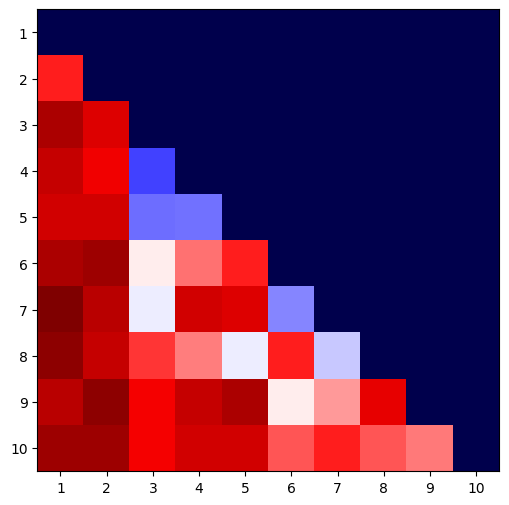

In [1094]:
subset = ['no_syntax']

# initialize matrix to be all the max and min numbers by all the max and min numbers
all_nums = len(np.arange(np.nanmin(O[O['condition'].isin(subset)].distractorNum.unique()).astype(int),
                         np.nanmax(O[O['condition'].isin(subset)].targetNum.unique()).astype(int)+1))
acc_mat = np.zeros((all_nums,all_nums)) # how many times did they get it right?
try_mat = np.zeros((all_nums,all_nums)) # how many tries did people get?

rt_mat = np.zeros((all_nums,all_nums))

for trial in O[O['condition'].isin(subset)][['gameID','targetNum', 'distractorNum', 'correct', 'RT']].iterrows():
    clear_output(wait=True)
    print(trial,end="\n\n\n")
    row = int(trial[1]['targetNum']) - 1
    col = int(trial[1]['distractorNum']) - 1
    acc = int(trial[1]['correct'])
    rt  = int(trial[1]['RT'])

    acc_mat[row,col] += acc
    try_mat[row,col] += 1
    rt_mat[row,col]  += rt



f , ax = plt.subplots(1,1,figsize=(6,6))
im = ax.imshow(np.nan_to_num(acc_mat / try_mat), cmap='seismic', interpolation='nearest')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(1,11))
ax.set_yticklabels(np.arange(1,11))
print("Done")
# np.nan_to_num(acc_mat / try_mat)

In [22]:
# try to plot the above over trial number instead of just magnitude difference. See about switch costs to new task, and how quickly (if at all) they're overcome

# # uncomment this line? I already can't remember
# O = O.sort_values(['gameID','initTime']).reset_index().drop(['index', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)

def getTrial(x):
    y = x # copy it
    first_index = x.index[0] - 1
    
    for trial in x.index:
        y['trialNum'][trial] = trial - first_index
        
    return y['trialNum']

O['trialNum'] = O.groupby('gameID').apply(lambda x: getTrial(x)).reset_index()['trialNum']



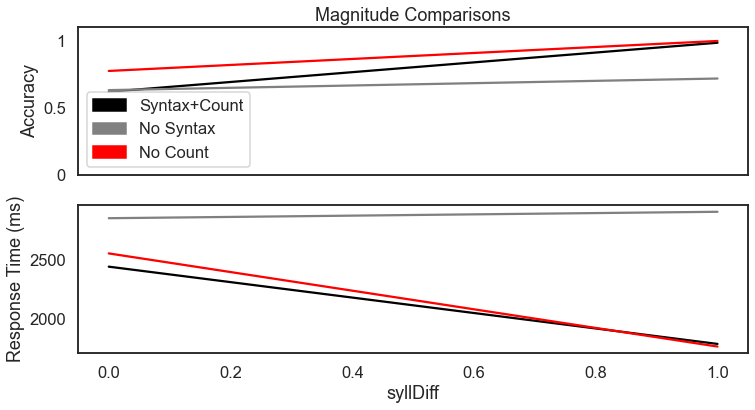

In [23]:
f , ax = plt.subplots(2,1,figsize=(12,6),sharex='col', sharey='row')

iv = 'syllDiff' # or maybe 'trialNum' or 

O[O['condition']=='control'].groupby(iv)[['correct']].mean().plot(ax=ax[0],title='Magnitude Comparisons',c='k',label="Syntax+Count")
O[O['condition']=='no_syntax'].groupby(iv)[['correct']].mean().plot(ax=ax[0],c='grey',label="No Syntax")
O[O['condition']=='no_count'].groupby(iv)[['correct']].mean().plot(ax=ax[0],c='red',label="No Count")

ax[0].set_ylim(0,1.1)
ax[0].set_yticks([0,.5,1])
ax[0].set_yticklabels([0,.5,1])

O[O['condition']=='control'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='k',legend=False)
O[O['condition']=='no_syntax'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='grey',legend=False)
O[O['condition']=='no_count'].groupby(iv)[['RT']].mean().plot(ax=ax[1],c='red',legend=False)

ax[1].set_xlabel(iv)
# ax[0].set_xticks(np.arange(1,10))
# ax[0].set_xticklabels(np.arange(1,10),rotation=0)

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Response Time (ms)")


blk_patch = mpatches.Patch(color='k', label='Syntax+Count')
gry_patch = mpatches.Patch(color='grey', label='No Syntax')
red_patch = mpatches.Patch(color='red', label='No Count')

ax[0].legend(handles=[blk_patch, gry_patch, red_patch])


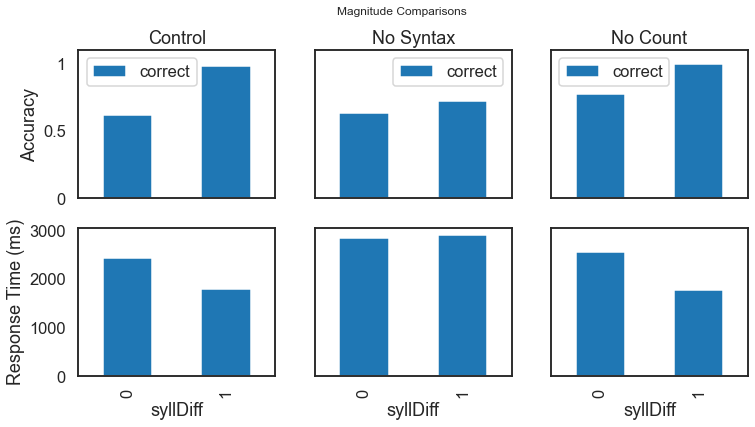

In [335]:
f , ax = plt.subplots(2,3,figsize=(12,6),sharex='col', sharey='row')

iv = 'syllDiff' # or maybe 'trialNum' or 
f.suptitle('Magnitude Comparisons')

O[O['condition']=='control'].groupby(iv)[['correct']].mean().plot.bar(ax=ax[0,0],title='Control',fill='k',label="Counting")
O[O['condition']=='no_syntax'].groupby(iv)[['correct']].mean().plot.bar(ax=ax[0,1],title='No Syntax',fill='grey',label="Unordered")
O[O['condition']=='no_count'].groupby(iv)[['correct']].mean().plot.bar(ax=ax[0,2],title='No Count',fill='red',label="Inconsistent")
# O.groupby(['syllDiff','condition'])[['correct']].mean().plot.bar(ax=ax[0],color=['red', 'blue', 'k'])

ax[0,0].set_ylim(0,1.1)
ax[0,0].set_yticks([0,.5,1])
ax[0,0].set_yticklabels([0,.5,1])

O[O['condition']=='control'].groupby(iv)[['RT']].mean().plot.bar(ax=ax[1,0],fill='k',legend=False)
O[O['condition']=='no_syntax'].groupby(iv)[['RT']].mean().plot.bar(ax=ax[1,1],fill='grey',legend=False)
O[O['condition']=='no_count'].groupby(iv)[['RT']].mean().plot.bar(ax=ax[1,2],fill='red',legend=False)

ax[1,0].set_xlabel(iv)
# ax[0].set_xticks(np.arange(1,10))
# ax[0].set_xticklabels(np.arange(1,10),rotation=0)

ax[0,0].set_ylabel("Accuracy")
ax[1,0].set_ylabel("Response Time (ms)")


blk_patch = mpatches.Patch(color='k', label='Syntax+Count')
gry_patch = mpatches.Patch(color='grey', label='No Syntax')
red_patch = mpatches.Patch(color='red', label='No Count')

# ax[0,0].legend(handles=[blk_patch, gry_patch, red_patch])


<AxesSubplot:xlabel='condition,syllDiff'>

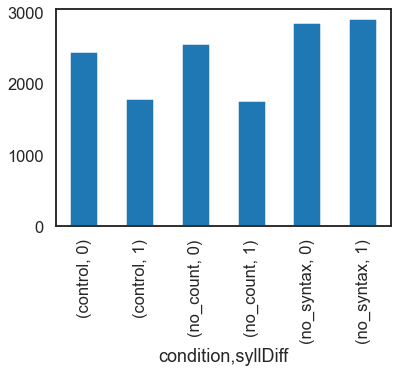

In [356]:
f , ax = plt.subplots(1,1,figsize=(6,4))


# m1 = O[O['condition']=='control'][O['syllDiff']==1][['RT']].mean() - O[O['condition']=='control'][O['syllDiff']==0][['RT']].mean()
# m2 = O[O['condition']=='no_count'][O['syllDiff']==1][['RT']].mean() - O[O['condition']=='no_count'][O['syllDiff']==0][['RT']].mean()
# m3 = O[O['condition']=='no_syntax'][O['syllDiff']==1][['RT']].mean() - O[O['condition']=='no_syntax'][O['syllDiff']==0][['RT']].mean()

O.groupby(['condition','syllDiff'])[['RT']].apply(lambda x: x['RT'].mean()).plot.bar()
# plt.bar(x=[1,2,3],height=[m1,m2,m3])

## Visualize the generalization phase

In [135]:
# What did people's generalizations look like? This is again more of a visualization
generalizations = W[W['eventType'] == 'generalization'].reset_index()['target']

G = pd.DataFrame(range(1,21),columns=['#'])
for j,g in enumerate(generalizations):
    gDF = pd.DataFrame(columns=['#',
                                'Targs{}'.format(j+1),
                                'Resps{}'.format(j+1),
                                'Cond{}'.format(j+1),
                                'RT{}'.format(j+1),
                                'WT{}'.format(j+1)                                                  # WT only new
                               ])
    
    for i in range(20):
        print("\033[1mGeneralization #{}\033[0m".format(j+1))
        print("Number: {}".format(i+1))
        clear_output(wait=True)
        
        # annoying thing: you have to literal_eval the target string to list...
        # & you have to interpret response string as json, when re-importing W from csv
        targ = ast.literal_eval(g)[i].replace("-","") if i < len(g) else "  "
        resp = json.loads(W[W['eventType'] == 'generalization'].reset_index(
            )['response'][j].replace("""["nu\'henu"]""","""['nuhenu']""").replace("\'", "\""))[str(i+1)][0].replace("-","")
        
        rt = np.sum(json.loads(W[W['eventType'] == 'generalization'].reset_index(
            )['RT'][j].replace("""["nu\'henu"]""","""['nuhenu']""").replace("\'", "\""))[str(i+1)])
        wt = np.sum(json.loads(W[W['eventType'] == 'generalization'].reset_index(                       # WT only new
            )['WT'][j].replace("""["nu\'henu"]""","""['nuhenu']""").replace("\'", "\""))[str(i+1)])                                                  # WT only new
        
        base = W[W['eventType'] == 'generalization'].reset_index()['condition'][j]
        newRow = pd.DataFrame([[i+1,targ,resp,base,rt,
                                wt                                                  # WT only new
                               ]], columns=gDF.columns)
        gDF = gDF.append(newRow)
    G = G.merge(gDF,on='#')

# # we could save this out, or just visualize it here:
G#.to_csv("Generalizations3.csv")


,#,Targs1,Resps1,Cond1,RT1,WT1,Targs2,Resps2,Cond2,RT2,WT2,Targs3,Resps3,Cond3,RT3,WT3,Targs4,Resps4,Cond4,RT4,WT4,Targs5,Resps5,Cond5,RT5,WT5,Targs6,Resps6,Cond6,RT6,WT6,Targs7,Resps7,Cond7,RT7,WT7,Targs8,Resps8,Cond8,RT8,WT8,Targs9,Resps9,Cond9,RT9,WT9,Targs10,Resps10,Cond10,RT10,WT10,Targs11,Resps11,Cond11,RT11,WT11,Targs12,Resps12,Cond12,RT12,WT12,Targs13,Resps13,Cond13,RT13,WT13,Targs14,Resps14,Cond14,RT14,WT14,Targs15,Resps15,Cond15,RT15,WT15,Targs16,Resps16,Cond16,RT16,WT16,Targs17,Resps17,Cond17,RT17,WT17,Targs18,Resps18,Cond18,RT18,WT18,Targs19,Resps19,Cond19,RT19,WT19,Targs20,Resps20,Cond20,RT20,WT20,Targs21,Resps21,Cond21,RT21,WT21,Targs22,Resps22,Cond22,RT22,WT22,Targs23,Resps23,Cond23,RT23,WT23,Targs24,Resps24,Cond24,RT24,WT24,Targs25,Resps25,Cond25,RT25,WT25,Targs26,Resps26,Cond26,RT26,WT26,Targs27,Resps27,Cond27,RT27,WT27,Targs28,Resps28,Cond28,RT28,WT28,Targs29,Resps29,Cond29,RT29,WT29,Targs30,Resps30,Cond30,RT30,WT30,Targs31,Resps31,Cond31,RT31,WT31,Targs32,Resps32,Cond32,RT32,WT32,Targs33,Resps33,Cond33,RT33,WT33,Targs34,Resps34,Cond34,RT34,WT34,Targs35,Resps35,Cond35,RT35,WT35,Targs36,Resps36,Cond36,RT36,WT36,Targs37,Resps37,Cond37,RT37,WT37,Targs38,Resps38,Cond38,RT38,WT38,Targs39,Resps39,Cond39,RT39,WT39,Targs40,Resps40,Cond40,RT40,WT40,Targs41,Resps41,Cond41,RT41,WT41,Targs42,Resps42,Cond42,RT42,WT42,Targs43,Resps43,Cond43,RT43,WT43,Targs44,Resps44,Cond44,RT44,WT44,Targs45,Resps45,Cond45,RT45,WT45,Targs46,Resps46,Cond46,RT46,WT46,Targs47,Resps47,Cond47,RT47,WT47,Targs48,Resps48,Cond48,RT48,WT48,Targs49,Resps49,Cond49,RT49,WT49,Targs50,Resps50,Cond50,RT50,WT50,Targs51,Resps51,Cond51,RT51,WT51,Targs52,Resps52,Cond52,RT52,WT52,Targs53,Resps53,Cond53,RT53,WT53,Targs54,Resps54,Cond54,RT54,WT54,Targs55,Resps55,Cond55,RT55,WT55,Targs56,Resps56,Cond56,RT56,WT56,Targs57,Resps57,Cond57,RT57,WT57,Targs58,Resps58,Cond58,RT58,WT58,Targs59,Resps59,Cond59,RT59,WT59,Targs60,Resps60,Cond60,RT60,WT60,Targs61,Resps61,Cond61,RT61,WT61,Targs62,Resps62,Cond62,RT62,WT62,Targs63,Resps63,Cond63,RT63,WT63,Targs64,Resps64,Cond64,RT64,WT64,Targs65,Resps65,Cond65,RT65,WT65,Targs66,Resps66,Cond66,RT66,WT66,Targs67,Resps67,Cond67,RT67,WT67,Targs68,Resps68,Cond68,RT68,WT68,Targs69,Resps69,Cond69,RT69,WT69,Targs70,Resps70,Cond70,RT70,WT70,Targs71,Resps71,Cond71,RT71,WT71,Targs72,Resps72,Cond72,RT72,WT72,Targs73,Resps73,Cond73,RT73,WT73,Targs74,Resps74,Cond74,RT74,WT74,Targs75,Resps75,Cond75,RT75,WT75,Targs76,Resps76,Cond76,RT76,WT76,Targs77,Resps77,Cond77,RT77,WT77,Targs78,Resps78,Cond78,RT78,WT78,Targs79,Resps79,Cond79,RT79,WT79,Targs80,Resps80,Cond80,RT80,WT80,Targs81,Resps81,Cond81,RT81,WT81,Targs82,Resps82,Cond82,RT82,WT82,Targs83,Resps83,Cond83,RT83,WT83,Targs84,Resps84,Cond84,RT84,WT84,Targs85,Resps85,Cond85,RT85,WT85,Targs86,Resps86,Cond86,RT86,WT86,Targs87,Resps87,Cond87,RT87,WT87,Targs88,Resps88,Cond88,RT88,WT88,Targs89,Resps89,Cond89,RT89,WT89,Targs90,Resps90,Cond90,RT90,WT90,Targs91,Resps91,Cond91,RT91,WT91
0,1,ko,ko,control,7365,792,ki,ki,no_count,23105,904,na,na,no_count,5873,3688,ke,ke,no_count,21420,2639,te,su,no_syntax,8664,1887,hi,se,no_syntax,3281,4333,ko,ko,no_count,5392,6073,nu,nu,no_count,6141,3799,tu,tu,control,7927,3431,te,kite,no_syntax,6376,4440,tu,tu,no_count,21240,873,nu,nu,no_count,7035,1294,hi,hi,no_count,8097,720,ti,hoti,no_syntax,7701,4937,so,so,control,18805,1224,ti,ke,no_syntax,15450,16375,so,so,no_count,9626,3879,hi,hi,control,8029,1403,ne,ne,no_count,6619,4619,te,te,control,3562,4881,ku,hesa,no_syntax,21697,2239,hu,ka,no_syntax,17510,1405,to,nuki,no_syntax,20486,11380,to,to,no_count,11955,1023,hi,hi,no_count,13842,18042,ta,ni,no_syntax,9151,4189,ka,heso,no_syntax,16353,3429,ti,kuno,no_syntax,11498,2192,no,no,no_syntax,30890,631,ka,ka,control,8063,722,ha,ha,no_count,17722,1104,tu,tu,no_count,3479,2774,ho,ho,no_count,8479,7452,hi,hi,control,10532,2013,ku,ku,control,4562,3735,te,te,control,7420,20856,ke,ke,no_count,9531,8409,no,su,no_syntax,10046,5764,ne,ne,control,5336,10539,he,he,no_syntax,5966,12989,so,

## Now make a DF of the generalization phase that's useful

In [26]:
G = W[W['eventType']=='generalization']


In [27]:
# decide if we want large bases (which also go up to 20 in generalization) or everything (only up to 15)
high_generalization = True

# What did people's generalizations look like? This is again more of a visualization
generalizations = W[W['eventType'] == 'generalization'].reset_index()[['gameID','target','base']]

# how high do we want to trace the generalization performance?
highest_number = 15 if high_generalization == False else 20 
bases = [2,3,4,5,8,10]
    

G = pd.DataFrame(range(0),columns=['num'])

for j,g in enumerate(generalizations['target']):
    gDF = pd.DataFrame(columns=['GID','num','targ','resp','base','RT',
                                'WT','cond'                                                           # WT only new
                               ])
    GID = generalizations['gameID'][j]
    
    for i in range(highest_number):
        print("\033[1mGeneralization #{}\033[0m".format(j+1))
        print("Number: {}".format(i+1))
        clear_output(wait=True)
        # annoying thing: you have to literal_eval the target string to list...
        # & you have to interpret response string as json, when re-importing W from csv
        
        if str(i+1) in json.loads(W[W['eventType'] == 'generalization'].reset_index(
            )['response'][j].replace("""["nu\'henu"]""","""['nuhenu']""").replace("\'", "\"")).keys():
        
            targ = ast.literal_eval(g)[i].replace("-","") if i < len(g) else "  "
            resp = json.loads(W[W['eventType'] == 'generalization'].reset_index(
                )['response'][j].replace("""["nu\'henu"]""","""['nuhenu']""").replace("\'", "\""))[str(i+1)][0].replace("-","")
            rt = np.sum(json.loads(W[W['eventType'] == 'generalization'].reset_index(
                )['RT'][j].replace("""["nu\'henu"]""","""['nuhenu']""").replace("\'", "\""))[str(i+1)])
            wt = np.sum(json.loads(W[W['eventType'] == 'generalization'].reset_index(          # WT only new
                )['WT'][j].replace("""["nu\'henu"]""","""['nuhenu']""").replace("\'", "\""))[str(i+1)])                                     # WT only new
            cond = W[W['eventType'] == 'generalization'].reset_index()['condition'][j]         # cond only new
            base = W[W['eventType'] == 'generalization'].reset_index()['base'][j]
        else:
            targ = np.nan
            resp = np.NAN # just to make this != targ
            rt = np.nan
            wt = np.nan                                                                        # WT only new
            cond = np.nan
            base = W[W['eventType'] == 'generalization'].reset_index()['base'][j]
        
        
        newRow = pd.DataFrame([[GID,i+1,targ,resp,base,rt,
                                wt,cond                                                             # WT only new
                               ]], columns=gDF.columns)
        gDF = gDF.append(newRow)
    G = G.append(gDF)

# now set the index to be some nice integers
G = G.set_index(np.arange(len(G)))
    
# we could save this out, or just visualize it here:
G.to_csv("datastructures/Generalizations3.csv")

print("Done")

Done


In [640]:
g = pd.read_csv("datastructures/Generalizations3.csv")
g = g.drop(labels=["Unnamed: 0"],axis=1)



# first let's gloss all the responses that people have given (take number words and map to arabic numerals; there will be some nonsense syllables left over)
units_dict = dict(g.groupby('GID').apply(lambda x : dict(zip([y for y in list(x['targ']) if len(y)==2],
                                                             [np.squeeze(x[x['targ']==z]['num']) for z in [y for y in list(x['targ']) if len(y)==2]] ))))
g['units'] = g['GID'].apply(lambda x: units_dict[x] ) # now add that list to every generalization phase trial


# post hoc, we have to correct the 'targ' column from no_syntax games, and then match all those games not on 'num', but on 'num' for other conditions and original meaning of targs for no_syntax
for game in W[W['condition']=='no_syntax'].gameID.unique():
    for i,row in W[W['gameID']==game][W['eventType']=='tutorial'][['cardinality','target']].iterrows():
        ind = g.loc[g['GID']==game].loc[g['num']==row['cardinality']].index[0]
        g.at[ind,'targ'] = row['target']


def gloss(string,system):
    st = string if type(string)==str else " " # if it's a nan, then forget about it
    for entry in system:
        char_gloss = "-"+str(system[entry])+"-"
        st = st.replace(entry,char_gloss) # replace number word in string (entry) with Arabic gloss (system[entry])
        st = st.replace("--","-")
        st = st.replace("- -","-")
        st = st[:-1] if st.endswith('-') else st
        st = st[1: ] if st.startswith('-') else st
    return st

def ungloss(string):
    st = string if type(string)==str else " " # if it's a nan, then forget about it
    st = st.split('-')
    if len(st) == 3:
        number = int(st[0]) * int(st[1]) + int(st[2])
    if len(st) == 2:
        number = int(st[0]) + int(st[1]) if st[0] > st[1] else int(st[0]) * int(st[1])
    if len(st) == 1:
        number = int(st[0])
    return number

g['gloss'] = g.apply(lambda x: gloss(x['resp'],x['units']),axis=1)
g['new'] = g['num'] > 10  # is this a number we haven't seen before?
g['targ_gloss'] = g.apply(lambda x: gloss(x['targ'],x['units']),axis=1)
g['match'] = g.apply(lambda x: ungloss(x['targ_gloss']),axis=1)

g[g['cond']=='no_count'].head(20)



/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_lau

,num,GID,targ,resp,base,RT,WT,cond,units,gloss,new,targ_gloss,match
20,1,G4,ki,ki,5,23105.0,904,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",1,False,1,1
21,2,G4,na,na,5,2512.0,920,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",2,False,2,2
22,3,G4,to,to,5,888.0,1008,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",3,False,3,3
23,4,G4,se,se,5,1256.0,960,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",4,False,4,4
24,5,G4,hu,hu,5,920.0,960,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",5,False,5,5
25,6,G4,huki,huki,5,520.0,2832,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",5-1,False,5-1,6
26,7,G4,huna,huna,5,913.0,2207,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",5-2,False,5-2,7
27,8,G4,huto,huto,5,840.0,1632,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",5-3,False,5-3,8
28,9,G4,huse,huse,5,1048.0,3456,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",5-4,False,5-4,9
29,10,G4,nahu,nahu,5,912.0,2896,no_count,"{'ki': 1, 'na': 2, 'to': 3, 'se': 4, 'hu': 5}",2-5,False,2-5,10


In [1178]:
g.columns

Index(['num', 'GID', 'targ', 'resp', 'base', 'RT', 'WT', 'cond', 'units',
       'gloss', 'new', 'targ_gloss', 'match'],
      dtype='object')

(0.0, 1.0)

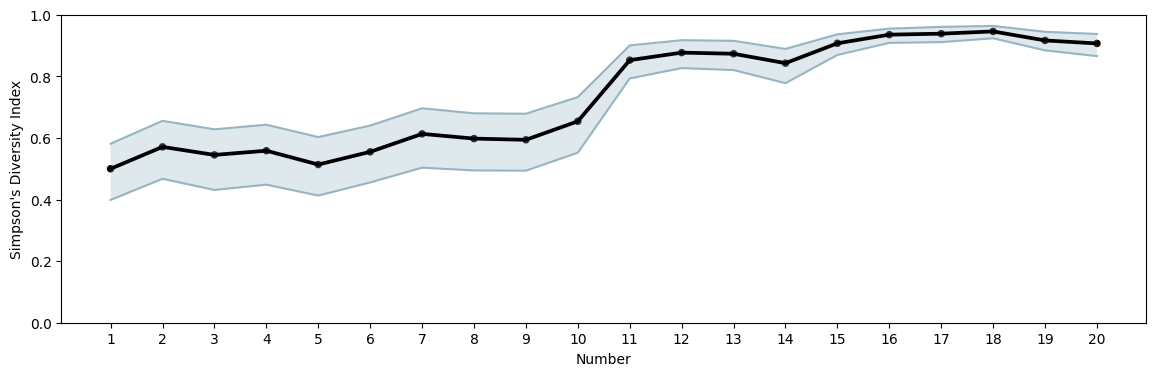

In [1202]:
classification = 'num' # 'Base' or 'num', or another distinction. 'match' matches by num, but no_syntax number words match with analogous word construction ("gloss") across games

# get the estimate for Simpson's diversity index
simpsons = g.groupby([classification,'gloss'])[['gloss']].count(
).groupby(classification)[['gloss']].apply(
    lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
    (x['gloss'].sum()*(x['gloss'].sum() - 1))))

simpsons.name = "Simpson's Diversity Index"



# now bootstrap some uncertainty around that measure
subset_sims = np.zeros([len(g[classification].unique()),0])

for i in range(500):
    np.random.seed(i)
    subset_games = np.random.choice(g.GID.unique(), len(g.GID.unique()), replace=True)
    subset_g = g[g['GID'].apply(lambda x: x in subset_games)]
    cur_sim = np.array(subset_g.groupby([classification,'gloss'])[['gloss']].count(
    ).groupby(classification)[['gloss']].apply(
        lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
                       (x['gloss'].sum()*(x['gloss'].sum() - 1)))))
    
    subset_sims = np.append(subset_sims,np.array([cur_sim]).T,axis=1)

upperCI = np.quantile(subset_sims, .975, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
lowerCI = np.quantile(subset_sims, .025, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})


f , ax1 = plt.subplots(1,1,figsize=(14,4))
temp = pd.DataFrame(simpsons).reset_index()
sns.pointplot(data=temp, x=classification, y="Simpson's Diversity Index",color='k',markers='.',ax=ax1)
sns.lineplot(data=upperCI, x=classification, y='upper',color='#97b4c2',ax=ax1)
sns.lineplot(data=lowerCI, x=classification, y='lower',color='#97b4c2',ax=ax1)
ax1.fill_between(upperCI[classification], lowerCI['lower'], upperCI['upper'], facecolor="#97b4c2", alpha=.3)
ax1.set_xlabel("Number")
ax1.set_ylim([0,1])

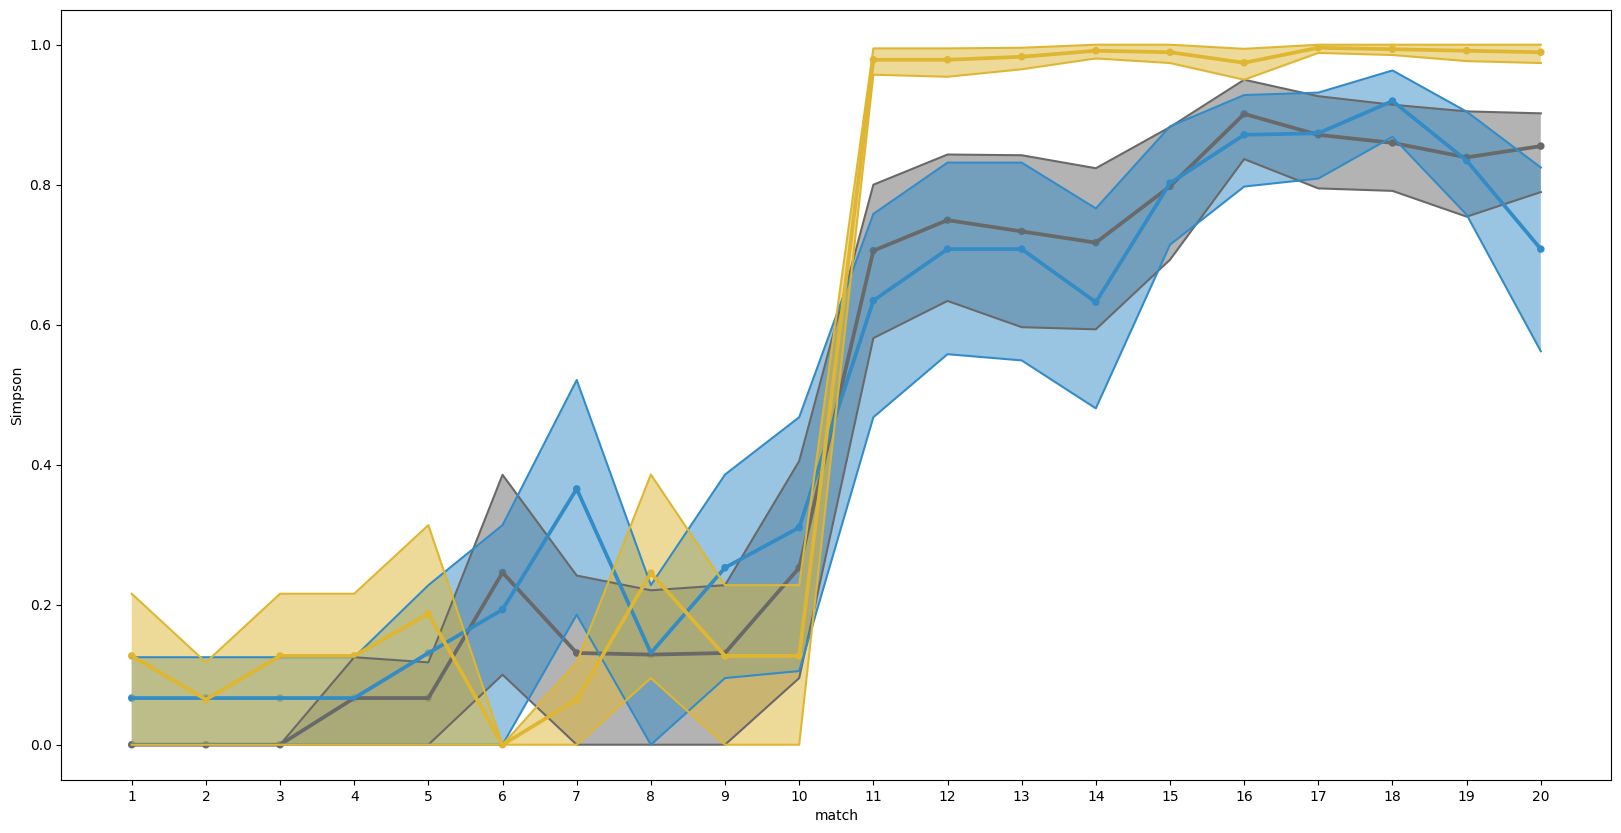

In [642]:
f , ax1 = plt.subplots(1,1,figsize=(20,10))

cond_colours = ['#696969', '#348CC7', '#DFB632']
conds = ['control','no_count','no_syntax']

b_s = {} # base_simpsons, but short name

for j,cond in enumerate(conds):
    gb = g[g['cond']==cond]
    
    classification = 'match' # could crumble the cookie in a different way though, like 10-15 vs 16-20, or based on whether an exponential rule is needed, etc

    # get the estimate for Simpson's diversity index
    simpsons = gb.groupby([classification,'gloss'])[['gloss']].count(
    ).groupby(classification)[['gloss']].apply(
        lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
        (x['gloss'].sum()*(x['gloss'].sum() - 1))))

    simpsons.name = 'Simpson'



    # now bootstrap some uncertainty around that measure
    subset_sims = np.zeros([len(gb[classification].unique()),0])

    for i in range(500):
        np.random.seed(i)
        subset_games = np.random.choice(gb.GID.unique(), len(gb.GID.unique()), replace=True)
        subset_gb = gb[gb['GID'].apply(lambda x: x in subset_games)]
        cur_sim = np.array(subset_gb.groupby([classification,'gloss'])[['gloss']].count(
        ).groupby(classification)[['gloss']].apply(
            lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
                           (x['gloss'].sum()*(x['gloss'].sum() - 1)))))

        subset_sims = np.append(subset_sims,np.array([cur_sim]).T,axis=1)

    upperCI = np.quantile(subset_sims, .975, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
    lowerCI = np.quantile(subset_sims, .025, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
    upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
    lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})
    
    b_s[cond] = subset_sims



    temp = pd.DataFrame(simpsons).reset_index()
    sns.pointplot(data=temp, x=classification, y='Simpson',color=cond_colours[j],markers='.',ax=ax1)
    sns.lineplot(data=upperCI, x=classification, y='upper',color=cond_colours[j],ax=ax1)
    sns.lineplot(data=lowerCI, x=classification, y='lower',color=cond_colours[j],ax=ax1)
    ax1.fill_between(upperCI[classification], lowerCI['lower'], upperCI['upper'], facecolor=cond_colours[j], alpha=.5)


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


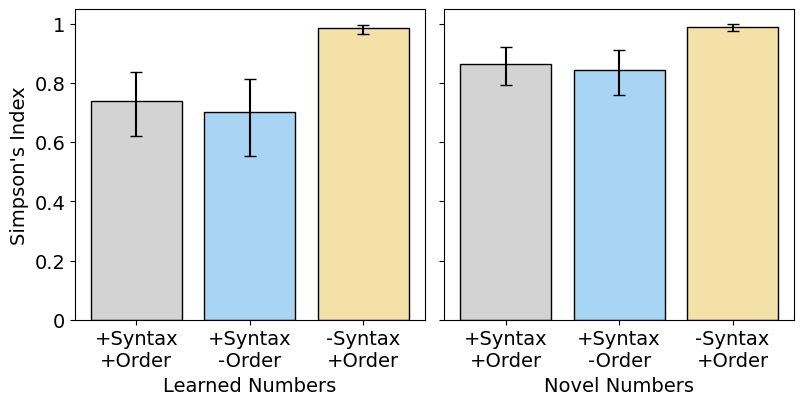

In [1002]:
f , ((ax2,ax3)) = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)

# cogsci_old

def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    return np.array([lowerCI,upperCI])

# average the Simpson's diversity estimates for LEARNED cardinalities within each base, and get the measure of uncertainty for each
ax2.bar(x = conds, height=[np.mean(b_s[cond][10:15]) for cond in conds],
        yerr=abs([np.mean(b_s[cond][10:15]) for cond in conds] - np.array([np.mean(getUpperLower(b_s[cond][10:15]),axis=1) for cond in conds]).T),
        color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
        capsize=4)
# ax2.set_title("Simpson (Old)")
ax2.set_xlabel("Learned Numbers")

# average the Simpson's diversity estimates for NOVEL cardinalities within each base, and get the measure of uncertainty for each
ax3.bar(x = conds, height=[np.mean(b_s[cond][15:]) for cond in conds],
        yerr=abs([np.mean(b_s[cond][15:]) for cond in conds] - np.array([np.mean(getUpperLower(b_s[cond][15:]),axis=1) for cond in conds]).T),
        color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
        capsize=4)
# ax3.set_title("Diversity")
ax3.set_xlabel("Novel Numbers")

ax2.set_ylabel("Simpson's Index")
ax3.yaxis.tick_left()
ax2.yaxis.tick_left()

ax3.yaxis.set_label_position("left")
ax2.yaxis.set_label_position("left")

# ax3.tick_params(axis='y', which='both', labelleft='off', labelright='on')
ax3.set_yticks([])
ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_yticks([0,.2,.4,.6,.8,1])
ax2.set_yticklabels([0,.2,.4,.6,.8,1])
# ax2.tick_params(axis='y', which='both', labelleft='on', labelright='off')


ax2.set_xticklabels(['+Syntax\n+Order','+Syntax\n-Order','-Syntax\n+Order'])

plt.tight_layout()

for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(14)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(14)
    
f.savefig('../results/plots/simpsonsExp2.pdf')


Text(0.5, 0, 'Base')

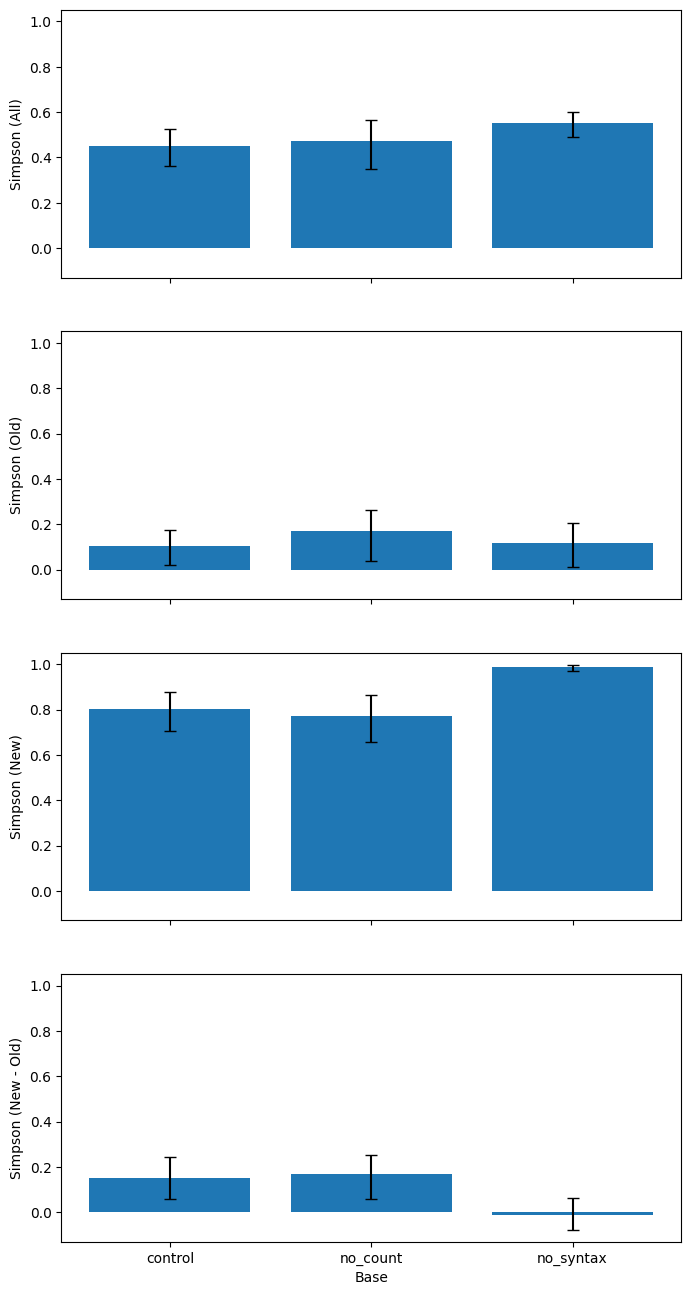

In [1004]:

f , ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1,figsize=(8,16), sharex=True, sharey=True)

def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
#     upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
#     lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})
    return np.array([lowerCI,upperCI])

# average the Simpson's diversity estimates for every cardinality within each base, and get the measure of uncertainty for each
ax1.bar(x = conds, height=[np.mean(b_s[cond]) for cond in conds],
        yerr=abs([np.mean(b_s[cond]) for cond in conds] - np.array([np.mean(getUpperLower(b_s[cond]),axis=1) for cond in conds]).T),
        capsize=4)
ax1.set_ylabel("Simpson (All)")

# average the Simpson's diversity estimates for LEARNED cardinalities within each base, and get the measure of uncertainty for each
ax2.bar(x = conds, height=[np.mean(b_s[cond][0:10]) for cond in conds],
        yerr=abs([np.mean(b_s[cond][0:10]) for cond in conds] - np.array([np.mean(getUpperLower(b_s[cond][0:10]),axis=1) for cond in conds]).T),
        capsize=4)
ax2.set_ylabel("Simpson (Old)")

# average the Simpson's diversity estimates for NOVEL cardinalities within each base, and get the measure of uncertainty for each
ax3.bar(x = conds, height=[np.mean(b_s[cond][10:]) for cond in conds],
        yerr=abs([np.mean(b_s[cond][10:]) for cond in conds] - np.array([np.mean(getUpperLower(b_s[cond][10:]),axis=1) for cond in conds]).T),
        capsize=4)
ax3.set_ylabel("Simpson (New)")

# ax1.set_ylim(0,1)




def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
#     upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
#     lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})
    return np.array([lowerCI,upperCI])


# average the Simpson's diversity estimates for difference between NOVEL & LEARNED cardinalities within each base, and get the measure of uncertainty for each
diffs = [np.mean(np.mean(b_s[cond][5:10],axis=0) - np.mean(b_s[cond][:5],axis=0)) for cond in conds]
diffsCI = abs(diffs - np.array([getUpperLower(np.mean(b_s[cond][5:10],axis=0) - np.mean(b_s[cond][:5],axis=0)) for cond in conds]).T)
ax4.bar(x = conds, height=diffs,
        yerr=diffsCI,
        capsize=4)
ax4.set_ylabel("Simpson (New - Old)")
ax4.set_xlabel("Base")



/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator


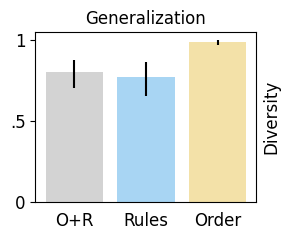

In [1291]:
# cogsci_new

f , ax = plt.subplots(1,1,figsize=(3,2.5))

d = .5 # how dispersed should the scatter dots be? Depends on width of bars
fs = 12 # fontsize for text in the figure
lw = 1.5 # linewidth for the errorbars
cs = 0 # capsize for the errorbars
ew = 0 # edgewidth for the errorbars

def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    return np.array([lowerCI,upperCI])


# # average the Simpson's diversity estimates for difference between NOVEL & LEARNED cardinalities within each base, and get the measure of uncertainty for each
# diffs = [np.mean(np.mean(b_s[cond][10:],axis=0) - np.mean(b_s[cond][0:10],axis=0)) for cond in conds]
# diffsCI = abs(diffs - np.array([getUpperLower(np.mean(b_s[cond][10:],axis=0) - np.mean(b_s[cond][0:10],axis=0)) for cond in conds]).T)
# ax.bar(x = conds, height=diffs,
#        yerr=diffsCI,
#        edgecolor='k',color=['lightgrey','#A8D5F3','#F3E1A8'],
#        error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})
# ax.set_ylabel("SI Diff.")
# ax.set_xlabel("Condition")
# ax.set_xticklabels(["Both","Rules","Order"])

def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    return np.array([lowerCI,upperCI])
ax.bar(x = conds, height=[np.mean(b_s[cond][10:]) for cond in conds],
       yerr=abs([np.mean(b_s[cond][10:]) for cond in conds] - np.array([np.mean(getUpperLower(b_s[cond][10:]),axis=1) for cond in conds]).T),
     #  edgecolor='k',
       color=['lightgrey','#A8D5F3','#F3E1A8'],
       error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
ax.set_ylabel("Diversity")
# ax.set_xticklabels(["Both  ","Rules","   Order"]) # rotation=300
ax.set_xticklabels([]) # rotation=300


ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are off

ax.yaxis.tick_left()
ax.set_yticks([0,.5,1])
ax.set_yticklabels(['0','.5','1'])
ax.set_title("Generalization")
ax.yaxis.set_label_position("right")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
ax.set_xticklabels(['O+R',"Rules","Order"])#,rotation=300)

plt.tight_layout()

f.savefig('../results/plots/cogsci23/Exp2simpsonsDiff.pdf', bbox_inches="tight")


In [1220]:
conds = ['control','no_count','no_syntax']

def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    return np.array([lowerCI,upperCI])

[np.array(getUpperLower(b_s[cond][10:])) for cond in conds]

[np.mean(b_s[cond][10:]) for cond in conds]

[0.802290076446265, 0.7726972234782762, 0.9866009590371341]

In [1212]:
getUpperLower(np.mean(b_s['control'],axis=0))

array([0.40784314, 0.4947619 ])

In [1215]:
SIs = np.append(np.append(b_s['control'],b_s['no_count'],axis=1), b_s['no_syntax'], axis=1)
SIbig = SIs[10:]
SIsml = SIs[:10]


In [1223]:
np.mean(getUpperLower(SIbig),axis=1)


array([0.67675561, 0.99722443])

In [1219]:
g.groupby(['cond'])['GID'].nunique()

cond
control      30
no_count     30
no_syntax    31
Name: GID, dtype: int64

In [1226]:
((0.802290076446265 * 30) + (0.7726972234782762 * 30 ) + (0.9866009590371341 * 31))/91

0.8553214145921693

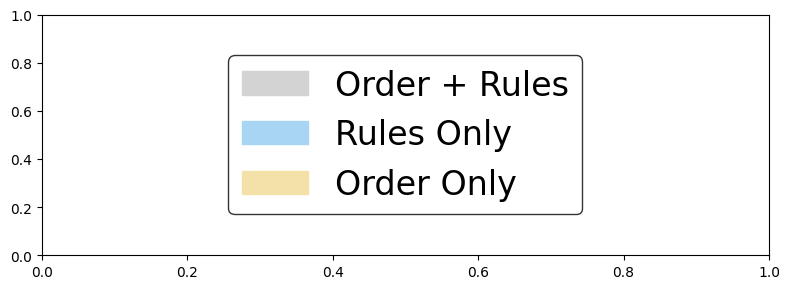

In [1269]:
# bolth_patch = mpatches.Patch(color='lightgrey', label='Both Consistent Rules & Order')
# rules_patch = mpatches.Patch(color='#A8D5F3',   label='Only Consistent Rules')
# order_patch = mpatches.Patch(color='#F3E1A8',   label='Only Consistent Order')

bolth_patch = mpatches.Patch(color='lightgrey', label='Order + Rules')
rules_patch = mpatches.Patch(color='#A8D5F3',   label='Rules Only')
order_patch = mpatches.Patch(color='#F3E1A8',   label='Order Only')

lfig = plt.figure(figsize(8,3))

plt.legend(handles=[bolth_patch, rules_patch, order_patch],
           loc='center',
           fontsize=24,
           edgecolor='k',
           shadow=False)

plt.tight_layout()

lfig.savefig('../results/plots/cogsci23/Exp2legend.pdf', bbox_inches="tight")


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


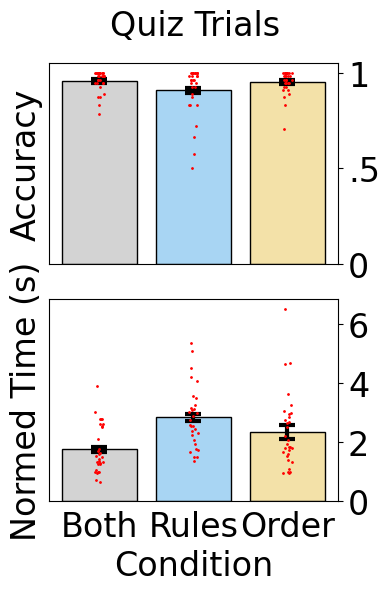

In [688]:
# trial structure looks like this:
# (stim. -> RT -> keypress. -> WT -> submit.)

# # might need to get rid of outliers:
# Q.loc[Q['timeDV'] > Q[Q['base']==3][['timeDV']].agg(['std'])['timeDV'][0]*3, 'timeDV'] = np.nan

# cogsci_old

fig , (ax1,ax2)= plt.subplots(2,1,figsize=(4,6),sharex=True)

def plotMain(dv,ax):
    titles = "Normed Time (s)" if dv == 'timeDV' else "Accuracy"
    # plot normalized time DV over game condition
    temp = get_confint(pd.DataFrame(Q.groupby(['condition'])[[dv]].agg(['mean', 'count', 'std'])))

    ax.bar(temp.reset_index()['condition'],
            height=temp[dv]['mean'],
            width=.8,
            yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
           edgecolor='k',color=['lightgrey','#A8D5F3','#F3E1A8'],
            error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})
    ax.set_ylabel("{}".format(titles))

    # now we can also plot each individual game on average and see how they distribute
    gameTimes = Q.groupby(['condition','gameID'])[[dv]].mean().reset_index()
    for i,cond in enumerate(conds):
        ax.scatter(i + np.random.random(len(gameTimes[gameTimes['condition'] == cond]))* .1 - .05,
                    gameTimes[gameTimes['condition'] == cond][dv],
                    zorder=10,s=1,c='r')
    ax.yaxis.tick_right()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

    return temp

plotMain('timeDV',ax2)
plotMain('correct',ax1)

fig.suptitle("Quiz Trials",fontsize=24)

ax1.set_yticks([0,.5,1])
ax1.set_yticklabels(["0",".5","1"])
ax2.set_yticks([0,2000,4000,6000])
ax2.set_yticklabels(["0","2","4","6"])
ax2.set_xticklabels(['Both','Rules','Order'])
ax2.set_xlabel('Condition')




ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off


plt.tight_layout()

fig.savefig('../results/plots/cogsci23/Exp2RT&acc.pdf', bbox_inches="tight")


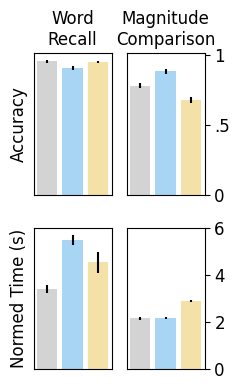

In [1282]:
# trial structure looks like this:
# (stim. -> RT -> keypress. -> WT -> submit.)

# # might need to get rid of outliers:
# Q.loc[Q['timeDV'] > Q[Q['base']==3][['timeDV']].agg(['std'])['timeDV'][0]*3, 'timeDV'] = np.nan

# cogsci_new

d = .5 # how dispersed should the scatter dots be? Depends on width of bars
fs = 12 # fontsize for text in the figure
lw = 1.5 # linewidth for the errorbars
cs = 0 # capsize for the errorbars
ew = 0 # edgewidth for the errorbars


fig , ((ax1,ax3),(ax2,ax4))= plt.subplots(2,2,figsize=(2.5,4),sharex=True,sharey='row')

def plotMain(dv,ax):
    titles = "Normed Time (s)" if dv == 'timeDV' else "Accuracy"
    # plot normalized time DV over game condition
    temp = get_confint(pd.DataFrame(Q.groupby(['condition'])[[dv]].agg(['mean', 'count', 'std'])))

    ax.bar(temp.reset_index()['condition'],
            height=temp[dv]['mean'],
            width=.8,
            yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
           #edgecolor='k',
           color=['lightgrey','#A8D5F3','#F3E1A8'],
            error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
    ax.set_ylabel("{}".format(titles))

    # now we can also plot each individual game on average and see how they distribute
    gameTimes = Q.groupby(['condition','gameID'])[[dv]].mean().reset_index()
#     for i,cond in enumerate(conds):
#         ax.scatter(i + np.random.random(len(gameTimes[gameTimes['condition'] == cond]))* d - (d/2),
#                     gameTimes[gameTimes['condition'] == cond][dv],
#                     zorder=10,s=1,c='r')
    ax.yaxis.tick_right()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fs)

    return temp

plotMain('timeDV',ax2)
plotMain('correct',ax1)

# Now we'll do the plots for the magnitude comparison task
CIctrl = np.array(get_confint(O[O['condition']=='control'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
Omeans = [O[O['condition']=='control'][['correct']].mean()[0],
               O[O['condition']=='no_count'][['correct']].mean()[0],
               O[O['condition']=='no_syntax'][['correct']].mean()[0]]
ax3.bar(x=['Both', 'Rules', 'Order'],
       height=Omeans,
       color=['lightgrey','#A8D5F3','#F3E1A8'],#edgecolor='k',
       yerr=abs(Omeans - np.squeeze(np.array([CIctrl,CInoco,CInosy]).T)),
       error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
# for i,cond in enumerate(['control','no_count','no_syntax']):
#         ax3.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['correct']].mean()))* d - (d/2),
#                     O[O['condition']==cond].groupby(['gameID'])[['correct']].mean(),
#                     zorder=10,s=1,c='r')

CIctrl = np.array(get_confint(O[O['condition']=='control'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
Omeans = [O[O['condition']=='control'][['RT']].mean()[0],
               O[O['condition']=='no_count'][['RT']].mean()[0],
               O[O['condition']=='no_syntax'][['RT']].mean()[0]]
ax4.bar(x=['Both', 'Rules', 'Order'],
       height=Omeans,
       color=['lightgrey','#A8D5F3','#F3E1A8'],#edgecolor='k',
       yerr=abs(Omeans - np.squeeze(np.array([CIctrl,CInoco,CInosy]).T)),
       error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
# for i,cond in enumerate(['control','no_count','no_syntax']):
#         ax4.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['RT']].mean()))* d - (d/2),
#                     O[O['condition']==cond].groupby(['gameID'])[['RT']].mean(),
#                     zorder=10,s=1,c='r')

        
# now formatting
for ax in [ax1,ax2]:
    for label in ax.get_yticklabels():
        label.set_visible(False)
for ax in [ax3,ax4]:
    # Change the labelling only
    ax.yaxis.set_tick_params(labelright='on', labelleft='off')

ax3.set_yticks([0,.5,1])
ax3.set_yticklabels(["0",".5","1"])
ax4.set_yticks([0,2000,4000,6000])
ax4.set_yticklabels(["0","2","4","6"])
# ax4.set_xticklabels(['O+R','Rules','Order'],rotation=300)
# ax4.set_xlabel('Condition')
ax3.yaxis.tick_right()
ax4.yaxis.tick_right()
# ax1.set_ylim(0,1.25)


for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
         ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(fs)
for item in ([ax4.title, ax4.xaxis.label, ax4.yaxis.label] +
         ax4.get_xticklabels() + ax4.get_yticklabels()):
    item.set_fontsize(fs)


ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False) # labels along the bottom edge are off
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False) # labels along the bottom edge are off

ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax4.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


# ax4.set_xticklabels(['Order+Rules','Order-Only','Rules-Only'],rotation=315)

ax1.set_title("Word\nRecall",fontsize=fs)
ax3.set_title("Magnitude\nComparison",fontsize=fs)
# ax2.set_xticklabels(['O+R','Rules','Order'],rotation=300)
plt.tight_layout()

fig.savefig('../results/plots/cogsci23/Exp2QO_RTacc.pdf', bbox_inches="tight")


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator


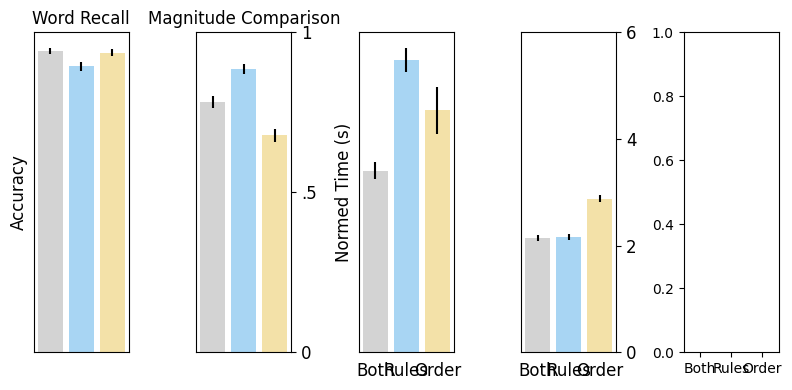

In [1258]:
# trial structure looks like this:
# (stim. -> RT -> keypress. -> WT -> submit.)

# # might need to get rid of outliers:
# Q.loc[Q['timeDV'] > Q[Q['base']==3][['timeDV']].agg(['std'])['timeDV'][0]*3, 'timeDV'] = np.nan

# cogsci_new

d = .5 # how dispersed should the scatter dots be? Depends on width of bars
fs = 12 # fontsize for text in the figure
lw = 1.5 # linewidth for the errorbars
cs = 0 # capsize for the errorbars
ew = 0 # edgewidth for the errorbars


fig , ((ax1,ax3,ax2,ax4,ax5))= plt.subplots(1,5,figsize=(8,4),sharex=True,sharey=False)

def plotMain(dv,ax):
    titles = "Normed Time (s)" if dv == 'timeDV' else "Accuracy"
    # plot normalized time DV over game condition
    temp = get_confint(pd.DataFrame(Q.groupby(['condition'])[[dv]].agg(['mean', 'count', 'std'])))

    ax.bar(temp.reset_index()['condition'],
            height=temp[dv]['mean'],
            width=.8,
            yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
           #edgecolor='k',
           color=['lightgrey','#A8D5F3','#F3E1A8'],
            error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
    ax.set_ylabel("{}".format(titles))

    # now we can also plot each individual game on average and see how they distribute
    gameTimes = Q.groupby(['condition','gameID'])[[dv]].mean().reset_index()
#     for i,cond in enumerate(conds):
#         ax.scatter(i + np.random.random(len(gameTimes[gameTimes['condition'] == cond]))* d - (d/2),
#                     gameTimes[gameTimes['condition'] == cond][dv],
#                     zorder=10,s=1,c='r')
    ax.yaxis.tick_right()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fs)

    return temp

plotMain('timeDV',ax2)
plotMain('correct',ax1)

# Now we'll do the plots for the magnitude comparison task
CIctrl = np.array(get_confint(O[O['condition']=='control'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
Omeans = [O[O['condition']=='control'][['correct']].mean()[0],
               O[O['condition']=='no_count'][['correct']].mean()[0],
               O[O['condition']=='no_syntax'][['correct']].mean()[0]]
ax3.bar(x=['Both', 'Rules', 'Order'],
       height=Omeans,
       color=['lightgrey','#A8D5F3','#F3E1A8'],#edgecolor='k',
       yerr=abs(Omeans - np.squeeze(np.array([CIctrl,CInoco,CInosy]).T)),
       error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
# for i,cond in enumerate(['control','no_count','no_syntax']):
#         ax3.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['correct']].mean()))* d - (d/2),
#                     O[O['condition']==cond].groupby(['gameID'])[['correct']].mean(),
#                     zorder=10,s=1,c='r')

CIctrl = np.array(get_confint(O[O['condition']=='control'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
Omeans = [O[O['condition']=='control'][['RT']].mean()[0],
               O[O['condition']=='no_count'][['RT']].mean()[0],
               O[O['condition']=='no_syntax'][['RT']].mean()[0]]
ax4.bar(x=['Both', 'Rules', 'Order'],
       height=Omeans,
       color=['lightgrey','#A8D5F3','#F3E1A8'],#edgecolor='k',
       yerr=abs(Omeans - np.squeeze(np.array([CIctrl,CInoco,CInosy]).T)),
       error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})
# for i,cond in enumerate(['control','no_count','no_syntax']):
#         ax4.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['RT']].mean()))* d - (d/2),
#                     O[O['condition']==cond].groupby(['gameID'])[['RT']].mean(),
#                     zorder=10,s=1,c='r')

        
# now formatting
for ax in [ax1,ax2]:
    for label in ax.get_yticklabels():
        label.set_visible(False)
for ax in [ax3,ax4]:
    # Change the labelling only
    ax.yaxis.set_tick_params(labelright='on', labelleft='off')

ax3.set_yticks([0,.5,1])
ax3.set_yticklabels(["0",".5","1"])
ax4.set_yticks([0,2000,4000,6000])
ax4.set_yticklabels(["0","2","4","6"])
ax4.set_xticklabels(['Both','Rules','Order'])
# ax4.set_xlabel('Condition')
ax3.yaxis.tick_right()
ax4.yaxis.tick_right()
# ax1.set_ylim(0,1.25)


for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
         ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(fs)
for item in ([ax4.title, ax4.xaxis.label, ax4.yaxis.label] +
         ax4.get_xticklabels() + ax4.get_yticklabels()):
    item.set_fontsize(fs)


ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False) # labels along the bottom edge are off
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=True) # labels along the bottom edge are off

ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax4.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off




ax1.set_title("Word Recall",fontsize=fs)
ax3.set_title("Magnitude Comparison",fontsize=fs)

plt.tight_layout()

fig.savefig('../results/plots/cogsci23/Exp2QO_RTacc.pdf', bbox_inches="tight")


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator


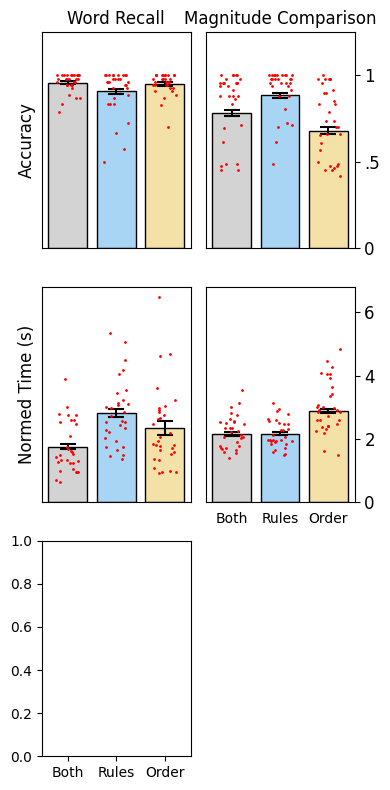

In [1234]:
# trial structure looks like this:
# (stim. -> RT -> keypress. -> WT -> submit.)

# # might need to get rid of outliers:
# Q.loc[Q['timeDV'] > Q[Q['base']==3][['timeDV']].agg(['std'])['timeDV'][0]*3, 'timeDV'] = np.nan

# cogsci_new

d = .5 # how dispersed should the scatter dots be? Depends on width of bars
fs = 12 # fontsize for text in the figure
lw = 1.5 # linewidth for the errorbars
cs = 6 # capsize for the errorbars


fig , ((ax1,ax3),(ax2,ax4),(ax5,ax6))= plt.subplots(3,2,figsize=(4,8),sharex=True,sharey='row')

def plotMain(dv,ax):
    titles = "Normed Time (s)" if dv == 'timeDV' else "Accuracy"
    # plot normalized time DV over game condition
    temp = get_confint(pd.DataFrame(Q.groupby(['condition'])[[dv]].agg(['mean', 'count', 'std'])))

    ax.bar(temp.reset_index()['condition'],
            height=temp[dv]['mean'],
            width=.8,
            yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
           edgecolor='k',color=['lightgrey','#A8D5F3','#F3E1A8'],
            error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':lw})
    ax.set_ylabel("{}".format(titles))

    # now we can also plot each individual game on average and see how they distribute
    gameTimes = Q.groupby(['condition','gameID'])[[dv]].mean().reset_index()
    for i,cond in enumerate(conds):
        ax.scatter(i + np.random.random(len(gameTimes[gameTimes['condition'] == cond]))* d - (d/2),
                    gameTimes[gameTimes['condition'] == cond][dv],
                    zorder=10,s=1,c='r')
    ax.yaxis.tick_right()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fs)

    return temp

plotMain('timeDV',ax2)
plotMain('correct',ax1)

# Now we'll do the plots for the magnitude comparison task
CIctrl = np.array(get_confint(O[O['condition']=='control'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['correct']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
Omeans = [O[O['condition']=='control'][['correct']].mean()[0],
               O[O['condition']=='no_count'][['correct']].mean()[0],
               O[O['condition']=='no_syntax'][['correct']].mean()[0]]
ax3.bar(x=['Both', 'Rules', 'Order'],
       height=Omeans,
       color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
       yerr=abs(Omeans - np.squeeze(np.array([CIctrl,CInoco,CInosy]).T)),
       error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':lw})
for i,cond in enumerate(['control','no_count','no_syntax']):
        ax3.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['correct']].mean()))* d - (d/2),
                    O[O['condition']==cond].groupby(['gameID'])[['correct']].mean(),
                    zorder=10,s=1,c='r')

CIctrl = np.array(get_confint(O[O['condition']=='control'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
Omeans = [O[O['condition']=='control'][['RT']].mean()[0],
               O[O['condition']=='no_count'][['RT']].mean()[0],
               O[O['condition']=='no_syntax'][['RT']].mean()[0]]
ax4.bar(x=['Both', 'Rules', 'Order'],
       height=Omeans,
       color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
       yerr=abs(Omeans - np.squeeze(np.array([CIctrl,CInoco,CInosy]).T)),
       error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':lw})
for i,cond in enumerate(['control','no_count','no_syntax']):
        ax4.scatter(i + np.random.random(len(O[O['condition']==cond].groupby(['gameID'])[['RT']].mean()))* d - (d/2),
                    O[O['condition']==cond].groupby(['gameID'])[['RT']].mean(),
                    zorder=10,s=1,c='r')

        
# now formatting
for ax in [ax1,ax2]:
    for label in ax.get_yticklabels():
        label.set_visible(False)
for ax in [ax3,ax4]:
    # Change the labelling only
    ax.yaxis.set_tick_params(labelright='on', labelleft='off')

ax3.set_yticks([0,.5,1])
ax3.set_yticklabels(["0",".5","1"])
ax4.set_yticks([0,2000,4000,6000])
ax4.set_yticklabels(["0","2","4","6"])
ax4.set_xticklabels(['Both','Rules','Order'])
# ax4.set_xlabel('Condition')
ax3.yaxis.tick_right()
ax4.yaxis.tick_right()
ax1.set_ylim(0,1.25)


for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
         ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(fs)
for item in ([ax4.title, ax4.xaxis.label, ax4.yaxis.label] +
         ax4.get_xticklabels() + ax4.get_yticklabels()):
    item.set_fontsize(fs)


ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False) # labels along the bottom edge are off
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False) # labels along the bottom edge are off

ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax4.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off




ax1.set_title("Word Recall",fontsize=fs)
ax3.set_title("Magnitude Comparison",fontsize=fs)
ax6.axis('off')

plt.tight_layout()

fig.savefig('../results/plots/cogsci23/Exp2QO_RTacc.pdf', bbox_inches="tight")


## Sanity check wtf is going on with the errorbars, the distributions look similar in Q and O

In [902]:
CIctrl = np.array(get_confint(O[O['condition']=='control'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(O[O['condition']=='no_count'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(O[O['condition']=='no_syntax'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']])[['ci95_hi','ci95_lo']]).T

Omeans = [O[O['condition']=='control'][['RT']].mean()[0],
               O[O['condition']=='no_count'][['RT']].mean()[0],
               O[O['condition']=='no_syntax'][['RT']].mean()[0]]

print(abs(Omeans - np.squeeze(np.array([CIctrl,CInoco,CInosy]).T)))
# print(Omeans)


[[56.40856287 52.22059258 60.32421513]
 [56.40856287 52.22059258 60.32421513]]


,mean,count,std
RT,2152.256725,1710.0,1190.109766


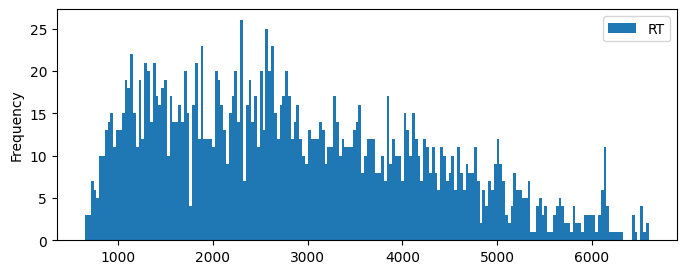

In [898]:
O[O['condition']=='no_syntax'][['RT']].plot.hist(bins=200)

O[O['condition']=='control'][['RT']].agg({'mean','count','std'}).T[['mean','count','std']]

In [945]:
get_confint(pd.DataFrame(Q.groupby(['condition'])[['correct']].agg(['mean', 'count', 'std'])))

correct                   ci95_hi   ci95_lo
               mean count       std                    
condition                                              
control    0.957460  1622  0.201880  0.967285  0.947635
no_count   0.908025  1620  0.289080  0.922102  0.893947
no_syntax  0.951555  1672  0.214769  0.961850  0.941260

In [893]:
get_confint(pd.DataFrame(O.groupby(['condition'])[['RT']].agg(['mean', 'count', 'std'])))

RT                         ci95_hi      ci95_lo
                  mean count          std                          
condition                                                          
control    2152.256725  1710  1190.109766  2208.665288  2095.848162
no_count   2167.069508  1525  1040.448638  2219.290101  2114.848916
no_syntax  2883.244565  2024  1384.652719  2943.568780  2822.920350

In [910]:
get_confint(pd.DataFrame(O.groupby(['condition'])[['correct']].agg(['mean', 'count', 'std'])))

correct                   ci95_hi   ci95_lo
               mean count       std                    
condition                                              
control    0.782456  1710  0.412696  0.802017  0.762895
no_count   0.884590  1525  0.319621  0.900632  0.868548
no_syntax  0.677866  2024  0.467410  0.698229  0.657502

In [944]:
o = O.groupby(['gameID'])[['condition','RT','correct','efficiency']].agg(
    {'condition':'unique' , 'RT':'mean', 'correct':'mean', 'efficiency':'mean'}).astype(
    {'condition':str , 'RT':float, 'correct':float, 'efficiency':float})
o
get_confint(pd.DataFrame(o.groupby(['condition'])[['correct']].agg(['mean', 'count', 'std'])))#.plot.bar(y='mean')


correct                   ci95_hi   ci95_lo
                   mean count       std                    
condition                                                  
['control']    0.836213    30  0.191340  0.904683  0.767743
['no_count']   0.910139    30  0.132274  0.957473  0.862805
['no_syntax']  0.729555    31  0.199562  0.799806  0.659304

In [948]:
q = Q.groupby(['gameID'])[['condition','timeDV','correct','efficiency']].agg(
    {'condition':'unique' , 'timeDV':'mean', 'correct':'mean', 'efficiency':'mean'}).astype(
    {'condition':str , 'timeDV':float, 'correct':float, 'efficiency':float})
q
get_confint(pd.DataFrame(q.groupby(['condition'])[['correct']].agg(['mean', 'count', 'std'])))#.plot.bar(y='mean')


correct                   ci95_hi   ci95_lo
                   mean count       std                    
condition                                                  
['control']    0.957672    30  0.055679  0.977597  0.937747
['no_count']   0.908025    30  0.131620  0.955124  0.860925
['no_syntax']  0.951511    31  0.063393  0.973827  0.929196

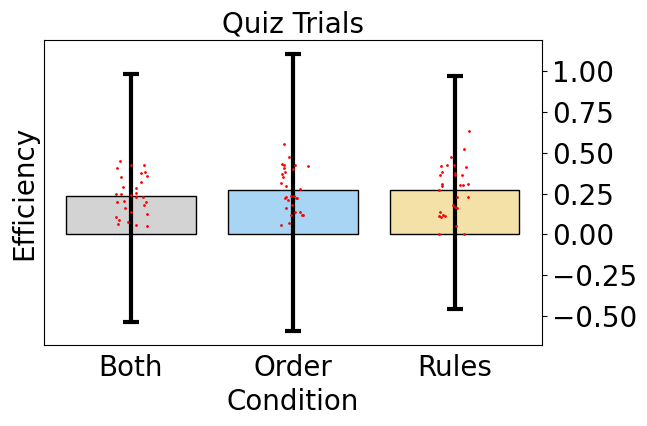

In [558]:

# cogsci_old
f , ax = plt.subplots(1,1, figsize=(6,4))

# get rid of outliers
Q['clean_eff'] = Q['efficiency']
Q.loc[Q['clean_eff'] < -2.5, 'clean_eff'] = np.nan


CIctrl = np.array(get_confint(Q[Q['condition']=='control'][['clean_eff']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T
CInoco = np.array(get_confint(Q[Q['condition']=='no_count'][['clean_eff']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T
CInosy = np.array(get_confint(Q[Q['condition']=='no_syntax'][['clean_eff']].agg({'mean','count','std'}).T)[['ci95_hi','ci95_lo']]).T

ax.bar(x=['Both','Order', 'Rules'],
       height=[Q[Q['condition']=='control'][['clean_eff']].mean()[0],
               Q[Q['condition']=='no_count'][['clean_eff']].mean()[0],
               Q[Q['condition']=='no_syntax'][['clean_eff']].mean()[0]],
       color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
       yerr=np.squeeze(np.array([CIctrl,CInoco,CInosy]).T),
       error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})


for i,cond in enumerate(['control','no_count','no_syntax']):
        ax.scatter(i + np.random.random(len(Q[Q['condition']==cond].groupby(['gameID'])[['clean_eff']].mean()))* .2 - .1,
                    Q[Q['condition']==cond].groupby(['gameID'])[['clean_eff']].mean(),
                    zorder=10,s=1,c='r')

ax.set_title("Quiz Trials")
ax.set_ylabel("Efficiency")
# ax.set_yticks([0,.5,1])
# ax.set_yticklabels(["0",".5","1"])
ax.yaxis.tick_right()
ax.set_xlabel("Condition")

plt.tight_layout()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

    
# f.savefig('../results/plots/cogsci23/Exp2Q_eff.pdf', bbox_inches="tight")


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


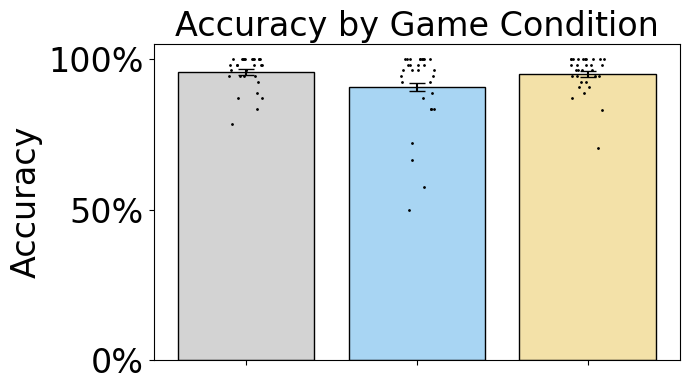

In [472]:
# cogsci_old

dv = 'correct'  # 'correct' or 'timeDV'
fig , ax = plt.subplots(1,1,figsize=(7,4),sharex=True)

titles = "Normed Time (ms)" if dv == 'timeDV' else "Accuracy"
ax.set_title("{} by Game Condition".format(titles))

temp = get_confint(pd.DataFrame(Q.groupby(['condition'])[[dv]].agg(['mean', 'count', 'std'])))

ax.bar(temp.reset_index()['condition'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
       edgecolor='k',color=['lightgrey','#A8D5F3','#F3E1A8'], # fill='grey'
        capsize=6)
ax.set_ylabel("{}".format(titles))
ax.set_xlabel("")
# ax.set_xlabel("Condition")
# ax.set_ylim(0,8000)
ax.set_yticks([0,.5,1])
ax.set_yticklabels(['0%','50%','100%'])


# now we can also plot each individual game on average and see how they distribute
gameTimes = Q.groupby(['condition','gameID'])[[dv]].mean().reset_index()
for i,cond in enumerate(conds):
    ax.scatter(i + np.random.random(len(gameTimes[gameTimes['condition'] == cond]))* .2 - .1,
                gameTimes[gameTimes['condition'] == cond][dv],
                zorder=10,s=1,c='k')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax.set_xticklabels([""])
# ax.set_xticklabels(['+Syntax\n+Order','+Syntax\n-Order','-Syntax\n+Order'])


plt.tight_layout()

fig.savefig('../results/plots/accExp2.pdf')


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


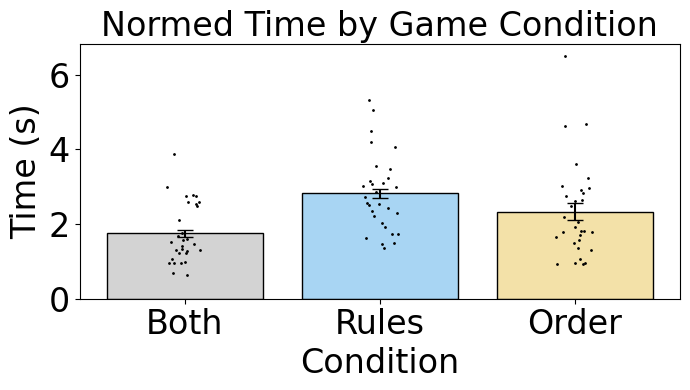

In [480]:
# cogsci_old

dv = 'timeDV'  # 'correct' or 'timeDV'
fig , ax = plt.subplots(1,1,figsize=(7,4),sharex=True)

titles = "Normed Time" if dv == 'timeDV' else "Accuracy"
ax.set_title("{} by Game Condition".format(titles))

temp = get_confint(pd.DataFrame(Q.groupby(['condition'])[[dv]].agg(['mean', 'count', 'std'])))

ax.bar(temp.reset_index()['condition'],
        height=temp[dv]['mean'],
        width=.8,
        yerr=[temp['ci95_hi']-temp[dv]['mean'], temp[dv]['mean']-temp['ci95_lo']],
       edgecolor='k',color=['lightgrey','#A8D5F3','#F3E1A8'], # fill='grey'
        capsize=6)
ax.set_ylabel("{}".format("Time (s)"))
ax.set_xlabel("Condition")
# ax.set_ylim(0,8000)
ax.set_yticks([0,2000,4000,6000])
ax.set_yticklabels(['0','2','4','6'])

# now we can also plot each individual game on average and see how they distribute
gameTimes = Q.groupby(['condition','gameID'])[[dv]].mean().reset_index()
for i,cond in enumerate(conds):
    ax.scatter(i + np.random.random(len(gameTimes[gameTimes['condition'] == cond]))* .2 - .1,
                gameTimes[gameTimes['condition'] == cond][dv],
                zorder=10,s=1,c='k')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax.set_xticklabels(['Both','Rules','Order'])


plt.tight_layout()

fig.savefig('../results/plots/rtExp2.pdf')


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


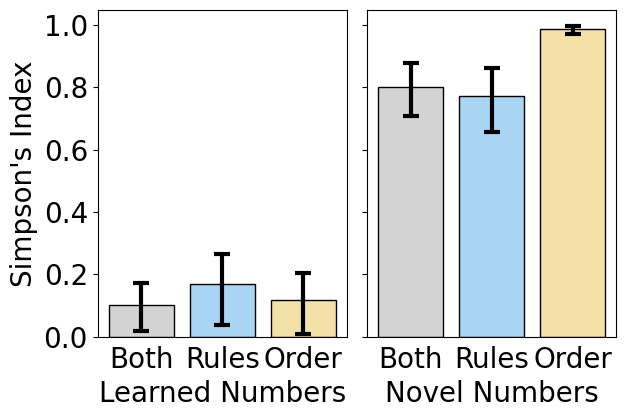

In [718]:
# cogsci_old

f , ((ax2,ax3)) = plt.subplots(1,2,figsize=(6,4), sharex=True, sharey=True)
def getUpperLower(sims):
    upperCI = np.squeeze(np.quantile(sims, .975, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    lowerCI = np.squeeze(np.quantile(sims, .025, axis=1, keepdims = True, interpolation = 'nearest')) # can't use 'method' because my python is outdated
    return np.array([lowerCI,upperCI])

# average the Simpson's diversity estimates for LEARNED cardinalities within each base, and get the measure of uncertainty for each
ax2.bar(x = conds, height=[np.mean(b_s[cond][0:10]) for cond in conds],
        yerr=abs([np.mean(b_s[cond][0:10]) for cond in conds] - np.array([np.mean(getUpperLower(b_s[cond][0:10]),axis=1) for cond in conds]).T),
        color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
        error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})
# ax2.set_title("Simpson (Old)")
ax2.set_xlabel("Learned Numbers")

# average the Simpson's diversity estimates for NOVEL cardinalities within each base, and get the measure of uncertainty for each
ax3.bar(x = conds, height=[np.mean(b_s[cond][10:]) for cond in conds],
        yerr=abs([np.mean(b_s[cond][10:]) for cond in conds] - np.array([np.mean(getUpperLower(b_s[cond][10:]),axis=1) for cond in conds]).T),
        color=['lightgrey','#A8D5F3','#F3E1A8'],edgecolor='k',
        error_kw={'linewidth':3,'capsize':6,'markeredgewidth':3})
# ax3.set_title("Diversity")
ax3.set_xlabel("Novel Numbers")
ax2.set_ylabel("Simpson's Index")

ax2.set_xticklabels(['Both','Rules','Order'])

plt.tight_layout()

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(20)
for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(20)


ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

f.savefig('../results/plots/cogsci23/Exp2simpsons.pdf', bbox_inches="tight")


In [ ]:
# https://www.jwilber.me/permutationtest/

In [719]:
def getSimpsonDiff(df1,df2,classification='num'):
#     df1 = g[g['cond']==c1]  # actually, no...
#     df2 = g[g['cond']==c2]
    
    # get the estimate for Simpson's diversity index in each condition
    simpsons1 = df1.groupby([classification,'gloss'])[['gloss']].count(
    ).groupby(classification)[['gloss']].apply(
        lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
        (x['gloss'].sum()*(x['gloss'].sum() - 1))))
    
    simpsons2 = df2.groupby([classification,'gloss'])[['gloss']].count(
    ).groupby(classification)[['gloss']].apply(
        lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
        (x['gloss'].sum()*(x['gloss'].sum() - 1))))
    
    simpsons_diff = simpsons1-simpsons2
    simpsons_diff.name = "Simpson's Diversity Index"
    
    return np.array([simpsons_diff])


def permuteSimpson(c1,c2,I,classification='num'):
    permuted_diffs = np.zeros([0,len(g.num.unique())])
    
    for i in range(I):
        print("Comparing {} & {}, working on permutation #{}".format(c1,c2,i+1))
        clear_output(wait=True)
        np.random.seed(i+1)
        gsub = g.loc[g['cond'].isin([c1,c2])]

        samples = np.random.choice(gsub.GID.unique(),len(gsub.GID.unique()),replace=True)
        gamelist1 = samples[:len(gsub[gsub['cond']==c1].GID.unique())]
        gamelist2 = samples[len(gsub[gsub['cond']==c1].GID.unique()):]
        
        permuted_diffs = np.append(permuted_diffs,
                                   getSimpsonDiff(g[g['GID'].isin(gamelist1)],g[g['GID'].isin(gamelist2)],classification), axis=0)
    print("Done")
    return permuted_diffs



In [720]:

g_ctrl, g_nc, g_ns = g[g['cond']=='control'], g[g['cond']=='no_count'], g[g['cond']=='no_syntax']

# get permutations (big matrix!) and observed differences (one obs for each cardinality) for each pair of conditions
p1, o1 = permuteSimpson('control','no_count',500, classification='match') , np.squeeze(getSimpsonDiff(g_ctrl, g_nc, classification='match'))
p2, o2 = permuteSimpson('control','no_syntax',500, classification='match') , np.squeeze(getSimpsonDiff(g_ctrl, g_ns, classification='match'))
p3, o3 = permuteSimpson('no_count','no_syntax',500, classification='match') , np.squeeze(getSimpsonDiff(g_nc, g_ns, classification='match'))

# get upper and lower CI-95% estimates for each bootstrap
u1, u2, u3 = map(lambda x: np.squeeze(np.quantile(x, .975, axis=0, keepdims = True, interpolation = 'nearest')), [p1, p2, p3])
l1, l2, l3 = map(lambda x: np.squeeze(np.quantile(x, .025, axis=0, keepdims = True, interpolation = 'nearest')), [p1, p2, p3])


Done


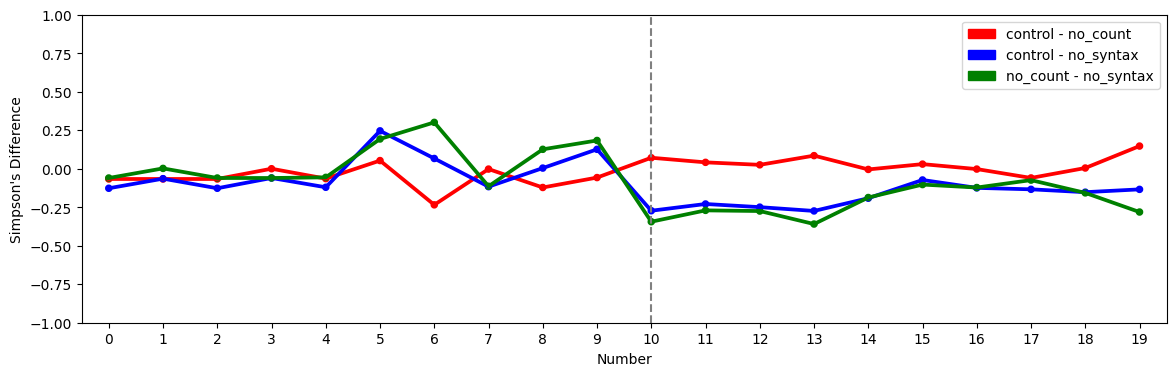

In [729]:
f , ax1 = plt.subplots(1,1,figsize=(14,4))

sns.pointplot(x=np.arange(len(o1)), y=o1, color='r',markers='.',ax=ax1)
# sns.lineplot(x=np.arange(len(o1)),  y=u1, color='r',ax=ax1)
# sns.lineplot(x=np.arange(len(o1)),  y=l1, color='r',ax=ax1)
# ax1.fill_between(np.arange(len(o1)), l1, u1, facecolor="r", alpha=.3)

sns.pointplot(x=np.arange(len(o2)), y=o2, color='b',markers='.',ax=ax1)
# sns.lineplot(x=np.arange(len(o2)),  y=u2, color='b',ax=ax1)
# sns.lineplot(x=np.arange(len(o2)),  y=l2, color='b',ax=ax1)
# ax1.fill_between(np.arange(len(o2)), l2, u2, facecolor="b", alpha=.3)

sns.pointplot(x=np.arange(len(o3)), y=o3, color='g',markers='.',ax=ax1)
# sns.lineplot(x=np.arange(len(o3)),  y=u3, color='g',ax=ax1)
# sns.lineplot(x=np.arange(len(o3)),  y=l3, color='g',ax=ax1)
# ax1.fill_between(np.arange(len(o3)), l3, u3, facecolor="g", alpha=.3)



ax1.set_xlabel("Number")
ax1.set_ylim([-1,1])
ax1.set_ylabel("Simpson's Difference")

patch1 = mpatches.Patch(color='r', label='control - no_count')
patch2 = mpatches.Patch(color='b', label='control - no_syntax')
patch3 = mpatches.Patch(color='g', label='no_count - no_syntax')
ax1.legend(handles=[patch1, patch2, patch3])

ax1.axvline(10,c='grey',linestyle='--')




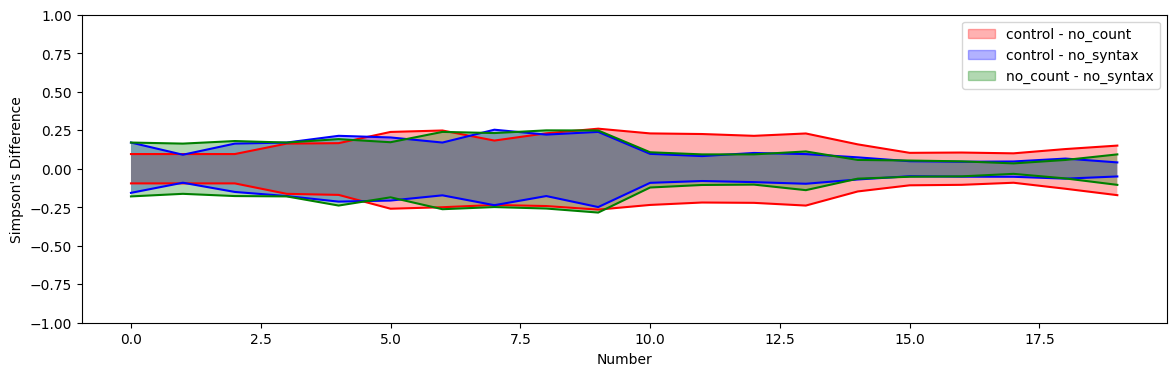

In [730]:
f , ax1 = plt.subplots(1,1,figsize=(14,4))

sns.lineplot(x=np.arange(len(o1)),  y=u1, color='r',ax=ax1)
sns.lineplot(x=np.arange(len(o1)),  y=l1, color='r',ax=ax1)
ax1.fill_between(np.arange(len(o1)), l1, u1, facecolor="r", alpha=.3)

sns.lineplot(x=np.arange(len(o2)),  y=u2, color='b',ax=ax1)
sns.lineplot(x=np.arange(len(o2)),  y=l2, color='b',ax=ax1)
ax1.fill_between(np.arange(len(o2)), l2, u2, facecolor="b", alpha=.3)

sns.lineplot(x=np.arange(len(o3)),  y=u3, color='g',ax=ax1)
sns.lineplot(x=np.arange(len(o3)),  y=l3, color='g',ax=ax1)
ax1.fill_between(np.arange(len(o3)), l3, u3, facecolor="g", alpha=.3)



ax1.set_xlabel("Number")
ax1.set_ylim([-1,1])
ax1.set_ylabel("Simpson's Difference")

patch1 = mpatches.Patch(color='r', alpha=.3, label='control - no_count')
patch2 = mpatches.Patch(color='b', alpha=.3, label='control - no_syntax')
patch3 = mpatches.Patch(color='g', alpha=.3, label='no_count - no_syntax')
ax1.legend(handles=[patch1, patch2, patch3])


In [906]:
glosses = pd.DataFrame(columns=[g.num.unique()])
cond='control'
for i,game in enumerate(g[g['cond']==cond].GID.unique()):
    new_row = g[g['GID']==game][['num','gloss']].set_index(['num']).T.rename(index={'gloss':g[g['GID']==game].T.loc['GID'].unique()})
    if i == 0:
        glosses = pd.DataFrame(new_row)
    else:
        glosses = glosses.append(new_row,ignore_index = False)    
glosses

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
[G2],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,2-5-5,2-5-5-1,2-5-5-2,2-5-5-3,2-5-5-4,2-5-2-5
[G13],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-1,2-5-1,2-5-3,2-5-4,2-5-5,2-5-5-1,2-5-5-2,2-5-5-3,2-5-5-4,2-2-5
[G27],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,3-5,4-4,3-5-2,3-5-3,3-5-4,4-5
[G23],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-1,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4
[G40],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,3-5,3-5-1,3-5-2,3-5-3,3-5-4,4-5
[G69],1,2,3,4,5,5-1,5-2,5-3,5-4,2-1,2-1-1,2-1-2,2-1-3,2-1-4,2-1-5,2-1-5-1,2-1-5-2,2-1-5-3,2-1-5-4,3-5
[G68],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,1-1,2-5-1,1-3,2-5-2,3-5-1,2-5-3,1-5-2,2-5-4,5-4-2-5,4-5
[G53],1,2,3,no,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,2-5-5,2-5-5-1,2-5-5-2,2-5-5-3,2-5-5-4,2-2-5
[G60],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-1,2-2,2-3,2-4,3-5,3-5-1,3-5-2,3-5-3,3-5-4,4-5
[G64],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-1,2-2,2-3,2-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,2-5-5


In [867]:
glosses = pd.DataFrame(columns=[g.num.unique()])
cond='no_count'
for i,game in enumerate(g[g['cond']==cond].GID.unique()):
    new_row = g[g['GID']==game][['num','gloss']].set_index(['num']).T.rename(index={'gloss':g[g['GID']==game].T.loc['GID'].unique()})
    if i == 0:
        glosses = pd.DataFrame(new_row)
    else:
        glosses = glosses.append(new_row,ignore_index = False)    
glosses

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
[G4],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,3-5,3-5-1,3-5-2,3-5-4,3-5-4,4-5
[G3],1,2,3,4,5,5-1,5-2,5-3,5-4,2-4,1-5-e,5-1-2,2-4-3,2-4-4,2-4-5,2-4-5-1,2-4-hihi,2-4-5-3,2-4-5-4,2-4-2
[G7],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,2-5-5,2-5-5-1,2-5-5-2,2-5-5-3,2-5-5-4,4-5
[G11],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,2-5-5,2-5-5-1,2-5-5-3,2-5-5-3,2-5-5-4,4-5
[G21],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,2-5-5,2-5-5-1,2-5-5-2,2-5-5-3,2-5-5-4,4-5
[G25],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-1,2-2,2-3,2-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,3-5
[G16],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,2-5-5,2-5-5-1,,,,
[G32],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-5-1,2-5-2,2-5-3,2-5-4,2-5-5,2-5-3,2-5-5-2,2-5-4,2-5-5-4,4-5
[G12],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,3-5-3,2-5-1,5-2-na,2-5-2,5-1-5-4,fasdjk,ka,klfa,kla,klfa
[G17],1,2,3,4,5,5-1,5-2,5-3,5-4,2-5,2-1,1-2,1-3,1-4,1-5,1-5-1,1-5-2,1-5-3,1-5-4,4-5


In [743]:
# now do the same thing as above, but collapse across cardinality as well
g_ctrl, g_nc, g_ns = g[g['cond']=='control'], g[g['cond']=='no_count'], g[g['cond']=='no_syntax']

# get permutations (big matrix!) and observed differences (one obs for each cardinality) for each pair of conditions
p1, o1 = np.mean(permuteSimpson('control','no_count',500, classification='match'),axis=1) , np.mean(np.squeeze(getSimpsonDiff(g_ctrl, g_nc, classification='match')))
p2, o2 = np.mean(permuteSimpson('control','no_syntax',500, classification='match'),axis=1) , np.mean(np.squeeze(getSimpsonDiff(g_ctrl, g_ns, classification='match')))
p3, o3 = np.mean(permuteSimpson('no_count','no_syntax',500, classification='match'),axis=1) , np.mean(np.squeeze(getSimpsonDiff(g_nc, g_ns, classification='match')))

# get upper and lower CI-95% estimates for each bootstrap
u1, u2, u3 = map(lambda x: np.squeeze(np.quantile(x, .975, axis=0, keepdims = True, interpolation = 'nearest')), [p1, p2, p3])
l1, l2, l3 = map(lambda x: np.squeeze(np.quantile(x, .025, axis=0, keepdims = True, interpolation = 'nearest')), [p1, p2, p3])


Done


In [907]:
glosses = pd.DataFrame(columns=[g.num.unique()])
cond='no_syntax'
for i,game in enumerate(g[g['cond']==cond].GID.unique()):
    new_row = g[g['GID']==game][['num','gloss']].set_index(['num']).T.rename(index={'gloss':g[g['GID']==game].T.loc['GID'].unique()})
    if i == 0:
        glosses = pd.DataFrame(new_row)
    else:
        glosses = glosses.append(new_row,ignore_index = False)    
glosses

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
[G9],3,4,5-2,5-4,5,2,5-3,1,2-5,5-1,5-1-3,5-1-4,5-1-5-2,5-1-5-4,5-1-5,5-1-5-3,5-1-5-3,5-1-1,5-1-2-5,4-5-1
[G10],5,5-3,5-1,2-5,5-4,2,4,5-2,3,1,5-5,5-5-3,5-5-1,5-5-2-5,5-5-si-4,5-5-2,5-5-4,5-5-5-2,5-5-3,5-3-3
[G15],5-1,5-4,2-5,5-3,5-2,1,4,5,3,2,5-t,5-h,2,5-s,5-n,5-1-1,5-1-4,5-1-5,5-1-3,5-1-2
[G20],5-1,2-5,5-4,oh-3,2,ko,ne,5-2,4,3,1,3,ka,tu,ko,na,su,ko-2,pi,ka
[G30],3,2-5,2,1,5-4,5-2,5-1,4,s-5,5-3,3-3,3-2-5,3-2,3-1,3-5-4,3-5-2,3-5-1,3-4,3-5,3-5-3
[G28],5-2,5-4,2,3,5-1,1,5,5-3,2-5,4,4-5-2,4-5-4,4-2,4-3,4-5-1,4-1,4-5,4-5-3,4-2-5,4-4
[G35],2,5,5-4,5-3,2-5,5-1,1,4,3,5-2,5-2-2,5-2-5,5-2-5-4,5-2-5-3,5-2-2-5,5-2-5-1,5-2-1,5-2-4,5-2-3,5-2-5-2
[G38],5-4,2-5,4,2,5,5-3,5-1,5-2,3,1,5-4-5-4,5-4-2-5-`,5-4-4,5-4-2,5-4-5,5-4-5-3,5-4-5-1,5-4-5-2,5-4-3,1-1
[G24],5,5-1,2-5,5-2,1,4,3,5-4,2,5-3,1-5,2-1,1-2,1-4,5-3,4-5,4-1,2-1,5-3-5,5-1-1
[G45],2-5,4,5-3,1,1,5-4,5-2,3,2,5-1,2-5-2-5,2-5-4,2-5-5,2-5-5-3,2-5-1,2-5-5-4,2-e-5-5-2,2-5-3,2-5-2,


(-0.15, 0.15)

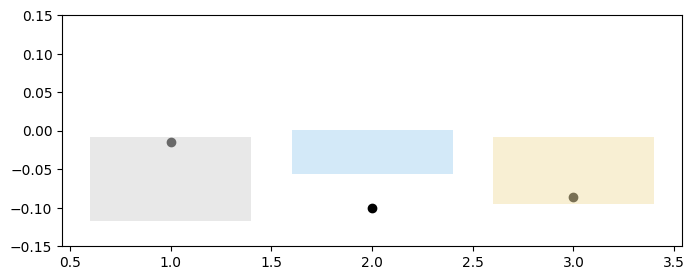

In [752]:
temp = np.array([[u1, u2, u3],[l1, l2, l3],[o1, o2, o3]])

f , ax = plt.subplots(1,1)
ax.bar([1,2,3] , bottom=temp[1], height=temp[0], color=['lightgrey','#A8D5F3','#F3E1A8'], alpha=.5)
ax.scatter([1,2,3] , y=temp[2], color='k')

ax.set_ylim(-.15,.15)

In [747]:
# suggestions from Judy, 2023-Jan-25:

# omnibus ANOVA (no within group variance, so no F-stat, but average distance between the three groups can have a null distribution, and then we see if )
# 1-10 on left, 11-20 on the right. Three bars in each half, easy to compare conditions within the novel vs old numbers
# ^ show the colourful plot from way up (descriptive statistics, or maybe just bar), but just summarize the last  analysis here verbally in text

np.array([[u1, u2, u3],[l1, l2, l3],[o1, o2, o3]])[1]

array([-0.11725008, -0.05564939, -0.0944664 ])